# IMAPAIN - Resting-State-Analysis-Script

This script analyses individual connectomes based on resting-state-fMRI the IMAGEN-project regarding its association with pain/psychophysical weakness at FU2 and FU3. In the publiocation FU2 is refered as T1 and FU3 as T2.

The notebook consists of following chapters:
   1. Prequesities
   1. Import of behavioral data
   2. Import fMRI-data
   3. First-level-analysis
   4. Second level analysis
   5. Post-hoc analysis 
   6. Supplemantary Material
   
**Please notice:** This notebook is performing highly computationally labourious operations. Therefore it is designed to be run on a HPC (https://www.rz.uni-kiel.de/en/our-portfolio/hiperf/nesh) . See ´Usage on HPC´ for detail

***

## Prequesities
Python-Modules used:

In [1]:
# basic file operations
import os
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

# Data handling and mathematical Operations
import numpy as np
import pandas as pd
from scipy.stats import zscore, pearsonr
import pickle

# Neuroimaging and Connectome
from nilearn.maskers import NiftiMapsMasker
from nilearn.datasets import fetch_atlas_difumo, load_mni152_template
from nilearn.image import load_img, index_img, resample_to_img, new_img_like
from nilearn.connectome import ConnectivityMeasure, sym_matrix_to_vec, vec_to_sym_matrix

# Statistics
from scipy.stats import ttest_rel
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.multitest import multipletests

# Visualization
from mne_connectivity.viz import plot_connectivity_circle
from mne.viz import circular_layout
from seaborn import violinplot
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib import colors, cm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from nilearn import plotting

/gxfs_home/cau/suknp018/miniconda3/envs/IMAPAIN_env/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Basic Constants

**user_base** is the user WORK-directory on the HPC.

**base** is the directory in which the different BIDS-directories are. There is one BIDS directory for *FU2* and one for *FU3* to be able to seperately run fmriprep on them to better account for anatomical differences (see https://neurostars.org/t/longitudinal-fmriprep/3892)

**basicdirectory** is the directory in which the behavioral data and derivatives for both timepoints are saved in the folders `/phenotype` (**phenotype_dir**) and `/derivatives` (**derivatives_dir**) more or less according to BIDS

**second_dir** is the directory, in which second-level results are saved, especially plots

In [2]:
user_base = '/gxfs_work1/cau/suknp018'
base = os.path.join(user_base, "My_Data")
basicdirectory = os.path.join(base, "IMAGEN", "data")
derivatives_dir = os.path.join(basicdirectory, 'derivatives')
phenotype_dir = os.path.join(basicdirectory, 'phenotype')
second_dir = os.path.join(derivatives_dir, 'nilearn/SecondLevel/')

### Usage on HPC 

This Script is made to be used on an HPC using the dask_jobqueue (http://jobqueue.dask.org/en/latest/)  and dask (https://dask.org/) package. 

The HPC used is the NEC HPC of Kiel University (https://www.rz.uni-kiel.de/en/our-portfolio/hiperf/nesh) based on a SLURM System (https://slurm.schedmd.com/documentation.html)

At first a Cluster and Client is initialized: 

In [3]:
# Initialize Cluster
cluster = SLURMCluster(
    n_workers=300,  # 300 is more or less max what the cluster allows per user
    cores=2,  # two cores are better tham just one. When using one connection often freezes.
    processes=1,
    memory="20GB",   # Must be scaled up to 64 if individual connectomes not precomputed
    shebang='#!/usr/bin/env bash',
    queue="cluster",
    walltime="01:00:00",
    local_directory='/tmp',
    death_timeout="4000s",   # must be this high otherwise looses workers
    interface="ib0",
    log_directory=f'{os.environ["HOME"]}/dask_jobqueue_logs/')

/gxfs_home/cau/suknp018/miniconda3/envs/IMAPAIN_env/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44793 instead
  warnings.warn(


In [4]:
# Initialize client
client = Client(cluster)

SLURM Script used:

In [5]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /gxfs_home/cau/suknp018/dask_jobqueue_logs//dask-worker-%J.err
#SBATCH -o /gxfs_home/cau/suknp018/dask_jobqueue_logs//dask-worker-%J.out
#SBATCH -p cluster
#SBATCH -n 1
#SBATCH --cpus-per-task=2
#SBATCH --mem=19G
#SBATCH -t 01:00:00

/gxfs_home/cau/suknp018/miniconda3/envs/IMAPAIN_env/bin/python -m distributed.cli.dask_worker tcp://172.18.4.13:45917 --nthreads 2 --memory-limit 18.63GiB --name dummy-name --nanny --death-timeout 4000s --local-directory /tmp --interface ib0 --protocol tcp://



Client and Cluster (workers need some time to establish, therefore they do not show up here)

In [6]:
client

<Client: 'tcp://172.18.4.13:45917' processes=0 threads=0, memory=0 B>

 ***
## Import of behavioral data
This part imports BIDS-confom behavioral data and transforms it in a workable pandas dataframe. Furthermore it checks wether all variables of interest exist for each participant and deletes participants without these.

**timepoints** are the timepoints of the IMAGEN-dataset used. They correspond to **T1 = FU2** and **T2 = FU3** in the publication. 

In [7]:
timepoints = ['FU2', 'FU3']

***add_column_to_dataframe*** 
extracts single column out of a dataframe and adds it to another datafram while keeping attention on the index (e.g. vp-code)

In [8]:
def add_column_to_dataframe(sourcedf, destinationdf, sourcecol, destinationcol):   # sourcedf needs to have column "participant_id" as defined in BIDS
    destinationdf.loc[:, destinationcol] = np.nan
    for x in destinationdf.index:
        if x in sourcedf.index: 
            destinationdf.loc[x, destinationcol] = sourcedf.loc[x, sourcecol]
    return destinationdf

***z-transform*** zscasle single column in df

In [9]:
def z_transform(dataframe, column):
    dataframe.loc[:, column] = zscore(dataframe.loc[:, column], nan_policy = 'omit')

***add_sum_score*** compute sum score in df

In [10]:
def add_sum_score(questionnaire_df, col_list, sum_name):
    questionnaire_df.loc[:,
                         sum_name] = questionnaire_df[col_list].sum(
                                                                    axis=1,
                                                                    skipna=True
                                                                    )

### Import relevant questionnaires

Both CSI questionnaires, participant list and DAWBA (just for age) 

In [11]:
participants = pd.read_csv(basicdirectory + "/participants.tsv",
                           sep="\t",
                           index_col='participant_id')
CSI_FU2 = pd.read_csv(phenotype_dir + "/CSI_CHILD_FU2.tsv",
                      sep="\t",
                      index_col='participant_id')
CSI_FU3 = pd.read_csv(phenotype_dir + "/CSI_FU3.tsv",
                      sep="\t",
                      index_col='participant_id')

# The following questionnaires are just imported for age etc.
# Those informations are not in the CSI-questionnaires but interesting for us

age_FU2 = pd.read_csv(phenotype_dir + "/IMAGEN_dawba_FU2.tsv",
                      sep="\t",
                      index_col=0,
                      usecols=[0, 1],
                      dtype=str)
age_FU3 = pd.read_csv(phenotype_dir + "/IMAGEN_dawba_FU3.tsv",
                      sep="\t",
                      index_col=0,
                      usecols=[0, 1],
                      dtype=str)

### Metadataframe 
Make a dataframe, which shows for which participant there are what kind of data.

***Pain-Questionnaires***

Check wether the VP completed the CSI-questionnaires.


In [12]:
participants["CSI_FU2"] = np.nan
participants["CSI_FU3"] = np.nan

In [13]:
for participant in participants.index:
    if participant in CSI_FU2.index:
        participants.loc[participant, 'CSI_FU2'] = True
    if participant in CSI_FU3.index:
        participants.loc[participant, 'CSI_FU3'] = True

***Resting-State-Imaging*** 

Check wether the preprocessed Resting-State-data is there

In [14]:
participants["Rest_FU2"] = np.nan
participants["Rest_FU3"] = np.nan

Because we preprocessed both timepoints independently there are two BIDS-Folders with each data from one timepoint.

In [15]:
for participant, idx in zip(participants.index, range(len(participants.index))):
    for timepoint in timepoints:
        if os.path.isfile(base + "/IMAGEN_" + timepoint + 
                          "/data/derivatives/fmriprep/" +
                          participant + "/ses-" + timepoint + "/func/" +
                          participant + "_ses-" + timepoint + 
                          "_task-rest_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz"):
            participants.loc[participant, str('Rest_' + timepoint)] = True
        else:
            print(participant + ' number ' + str(idx) + ' at ' + timepoint + ' is missing')

# fill nan with False
for i in participants.index:
    for j in participants.columns[2:]:
        if participants.loc[i, j] is not True:
            participants.loc[i, j] = False
            participants.loc[i, j]


sub-000015059321 number 107 at FU2 is missing
sub-000015312177 number 108 at FU2 is missing
sub-000016069129 number 113 at FU2 is missing
sub-000019340307 number 136 at FU2 is missing
sub-000038916315 number 282 at FU2 is missing


### Subdataframe

Make dataframe with participants that are usable for further analysises based on the metadataframe
They should have:
1. Resting-state data for FU2 and FU3
2. CSI-questionnaire data for FU2 and FU3

Drop every participants that does not meet criteria :

In [16]:
incomplete = []
for i in participants.index:
    if not (participants.loc[i, 'CSI_FU2'] is True and
            participants.loc[i, 'CSI_FU3'] is True and
            participants.loc[i, 'Rest_FU3'] is True and
            participants.loc[i, 'Rest_FU2']):
        incomplete.append(i)
participants_usable = participants.drop(incomplete)  # drop who does not meet criteria 
print(str(participants_usable.shape[0]) +
      ' subjects are usable for this analysis')

690 subjects are usable for this analysis


Make new dataframe based on the previous one where all participants meet criteria and that we use in the analysis. Import data about sex and recode it for later compatibility with statistic models. This is the dataframe used in all furtther analysis

In [17]:
df = participants_usable[['sex', 'recruitment centre']].copy()

In [18]:
#  recode sex
for sub in df.index:
    if df.loc[sub, 'sex'] == 'M':
        df.loc[sub, 'sex'] = 1
    else:
        df.loc[sub, 'sex'] = 0
df.loc[:, 'sex'] = df.loc[:, 'sex'].astype('int')

***CSI***

Make Pain/Weakness-sum-score according to e.g. **Meester et al (2003)** *https://doi.org/10.1093/jpepsy/jsg031*

Define which items are the one of interest:

In [19]:
pain_score_cols = ['item34', 'item3', 'item12', 'item11',
                   'item33', 'item17', 'item7',
                   'item6', 'item18', 'item9']

Compute scores for both timepoints

In [20]:
for csi in [CSI_FU2, CSI_FU3]:
    add_sum_score(csi, pain_score_cols, 'csi_pain_sum')

Add the scores to the dataframe

In [21]:
# csi pain sum
df = add_column_to_dataframe(CSI_FU2, df, 'csi_pain_sum', 'FU2_csi_pain_sum')
df = add_column_to_dataframe(CSI_FU3, df, 'csi_pain_sum', 'FU3_csi_pain_sum')

z-scale the computed scores

In [22]:
# z-scale everything
for col in ['FU2_csi_pain_sum', 'FU3_csi_pain_sum']:
    z_transform(df, col)

Furthermore add raw scores once again

In [23]:
# csi pain sum
df = add_column_to_dataframe(CSI_FU2, df, 'csi_pain_sum', 'FU2_csi_pain_sum_raw')
df = add_column_to_dataframe(CSI_FU3, df, 'csi_pain_sum', 'FU3_csi_pain_sum_raw')

Have a look on the dataframe

In [24]:
df.head()

sex recruitment centre  FU2_csi_pain_sum  FU3_csi_pain_sum  \
participant_id                                                                 
sub-000000112288    1              PARIS         -0.238478         -0.032431   
sub-000000240546    1             BERLIN         -0.826157         -0.629164   
sub-000000308867    1         NOTTINGHAM          0.349201         -0.629164   
sub-000000469693    0            HAMBURG          0.055361         -0.629164   
sub-000000613223    1            DRESDEN         -0.826157         -0.629164   

                  FU2_csi_pain_sum_raw  FU3_csi_pain_sum_raw  
participant_id                                                
sub-000000112288                   2.0                   2.0  
sub-000000240546                   0.0                   0.0  
sub-000000308867                   4.0                   0.0  
sub-000000469693                   3.0                   0.0  
sub-000000613223                   0.0                   0.0

Look at the intercorrelations between the variables of interest:

Text(0.5, 1.0, 'Correlation Matrix')

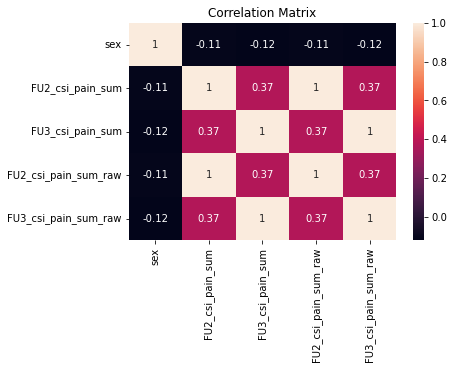

In [25]:
df_numeric = df.select_dtypes(include=['int64', 'float64'])

corrs_df = pd.DataFrame(np.zeros((df_numeric.shape[1],
                                  df_numeric.shape[1])))
corrs_df = corrs_df.set_axis(df_numeric.columns).set_axis(df_numeric.columns, axis=1)

ps_df = corrs_df.copy()

for x in range(df_numeric.shape[1]):
    for y in range(df_numeric.shape[1]):
        corr_df = df_numeric.iloc[:,
                                  [y, x]].dropna(how='any')
        r, p = pearsonr(corr_df.iloc[:,
                                     0],corr_df.iloc[:, 1])
        corrs_df.iloc[x, y] = r
        ps_df.iloc[x, y] = p
fig_1 = sns.heatmap(corrs_df,
                    annot=True,
                   )
fig_1.set_title('Correlation Matrix')

Text(0.5, 1.0, 'Correlation Matrix - P Values')

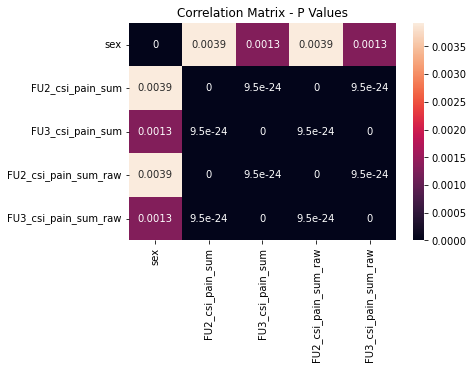

In [26]:
fig_2 = sns.heatmap(ps_df, annot=True)
fig_2.set_title('Correlation Matrix - P Values')

***Age*** 

Get information about the age of the participants and put it in the dataframe.

In [27]:
#  Need to reformat the index to fit to the main dataframe
#  add 'sub-'' to column
index_list = age_FU2.index

index_new = []
for index in index_list:
    index = str('sub-'+index)
    index_new.append(index)
age_FU2.loc[:, 'participants_id'] = index_new
age_FU2.set_index('participants_id', inplace=True)

# add 'sub-'' to column
index_list = age_FU3.index

index_new = []
for index in index_list:
    index = str('sub-'+index)
    index_new.append(index)
age_FU3.loc[:, 'participants_id'] = index_new
age_FU3.set_index('participants_id', inplace=True)

# add to df
df = add_column_to_dataframe(age_FU2, df, 'PSC2', 'FU2_age')
df.loc[:, 'FU2_age'] = df.loc[:, 'FU2_age'].astype('float')

df = add_column_to_dataframe(age_FU3, df, 'PSC2', 'FU3_age')
df.loc[:, 'FU3_age'] = df.loc[:, 'FU3_age'].astype('float')

### Participants informations

Get and plot information about participants sex and age.

How many participants did participate?

In [28]:
print(str(df.shape[0]) + ' subjects have complete datasets')

690 subjects have complete datasets


How is sex represented?

In [29]:
print(str(df.loc[:, 'sex'].sum()) + ' males and ' +
      str(df.shape[0] - df.loc[:, 'sex'].sum()) + ' females')

291 males and 399 females


What is the age and age differences betwen the timepoints?

In [30]:
print('The mean age at FU2 is {} ({}) and at FU3 {} ({}). The mean time between the two timepoints is {} ({})'
      .format(df.loc[:, 'FU2_age'].mean(), df.loc[:, 'FU2_age'].std(),
              df.loc[:, 'FU3_age'].mean(), df.loc[:, 'FU3_age'].std(),
              df.loc[:, 'FU3_age'].subtract(df.loc[:, 'FU2_age']).mean(),
              df.loc[:, 'FU3_age'].subtract(df.loc[:, 'FU2_age']).std()
             ))

The mean age at FU2 is 18.452830188679247 (0.7016560364636819) and at FU3 22.002936857562407 (0.6795263556816563). The mean time between the two timepoints is 3.552941176470588 (0.757966154702575)


Plot pain/psychophysical weakness-scores per timepoint, grouped for sex.

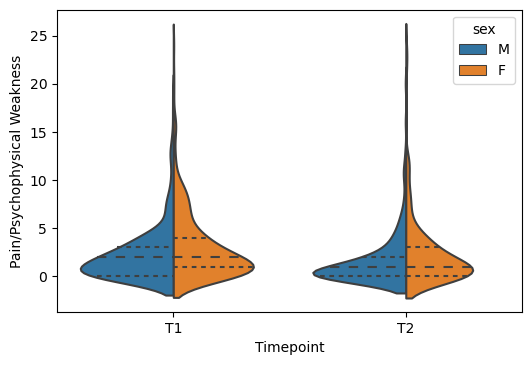

In [31]:
graphical_df = pd.concat([df.loc[:, ['FU2_csi_pain_sum_raw', 'sex']],
                          df.loc[:, ['FU3_csi_pain_sum_raw', 'sex']]],
                         axis=0)
graphical_df.set_axis(['Age 19', 'sex', 'Age 23'], axis=1, inplace=True)

age = []
csi_score =[]

for sub in range(graphical_df.shape[0]):
    if np.isnan(graphical_df.iloc[sub, 0]):
        age.append('T2')
        csi_score.append(graphical_df.iloc[sub, 2])
    else:
        age.append('T1')
        csi_score.append(graphical_df.iloc[sub, 0])

graphical_df['Age'] = age
graphical_df['Pain/Psychophysical Weakness'] = csi_score
graphical_df['sex'].replace(1, 'M', inplace=True)
graphical_df['sex'].replace(0, 'F', inplace=True)

fig = plt.figure(dpi=100)
boxi = violinplot(data=graphical_df,
                  x='Age',
                  y='Pain/Psychophysical Weakness',
                  inner="quartile",
                  hue='sex',
                  split=True,
                 figsize=(5,5))
boxi.set_xlabel('Timepoint')
fig.savefig(os.path.join(second_dir,'violin_plot_csi-scores.svg'))
plt.show()

Plot pain/psychophysical weakness-scores difference grouped for sex.

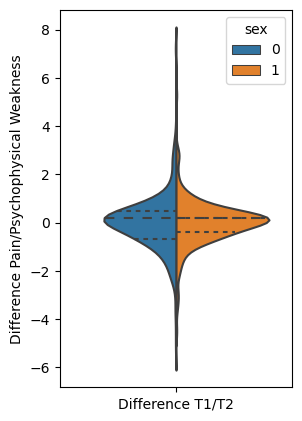

In [32]:
graphical_df = pd.concat([df.loc[:, 'FU3_csi_pain_sum'].subtract(df.loc[:, 'FU2_csi_pain_sum']),
                          df.loc[:, 'sex']],
                         axis=1)
graphical_df.set_axis(['Difference Pain/Psychophysical Weakness', 'sex'], axis=1, inplace=True)

age = []
csi_score =[]

#graphical_df.replace('M',1, inplace = True)
#graphical_df.replace('F',0, inplace = True)

graphical_df[''] = ['Difference T1/T2']*graphical_df.shape[0]

fig = plt.figure(figsize = (3,5),dpi=100)
boxi = violinplot(data=graphical_df,
                  y='Difference Pain/Psychophysical Weakness',
                  inner="quartile",
                  hue='sex',
                  split=True,
                 x = '')
fig.savefig(os.path.join(second_dir,'violin_plot_csi-difference.svg'))
plt.show()

In [33]:
print('''Mean P/PW-score in relation to maximal score at T1 is {:.4f} (std={:.4f}), at T2 {:.4f} (std={:.4f})
        In mean, the score declined significantly from T1 to T2 by {:.4f} (std={:.4f}, t={:.4f}, p={:.4f})'''.format(
                                                                           df.loc[:, 'FU2_csi_pain_sum_raw'].mean()/40,
                                                                           (df.loc[:, 'FU2_csi_pain_sum_raw']/40).std(),
                                                                           df.loc[:, 'FU3_csi_pain_sum_raw'].mean()/40,
                                                                           (df.loc[:, 'FU3_csi_pain_sum_raw']/40).std(),
                                                                           df.loc[:, 'FU3_csi_pain_sum_raw'].subtract(df.loc[:, 'FU2_csi_pain_sum_raw']).mean()/40,
                                                                           ((df.loc[:, 'FU3_csi_pain_sum_raw'].subtract(df.loc[:, 'FU2_csi_pain_sum_raw']))/40).std(),
                                                                           ttest_rel(df.loc[:, 'FU2_csi_pain_sum_raw'], df.loc[:, 'FU3_csi_pain_sum_raw'])[0],
                                                                           ttest_rel(df.loc[:, 'FU2_csi_pain_sum_raw'], df.loc[:, 'FU3_csi_pain_sum_raw'])[1]
                                                                           ))

Mean P/PW-score in relation to maximal score at T1 is 0.0703 (std=0.0851), at T2 0.0527 (std=0.0839)
        In mean, the score declined significantly from T1 to T2 by -0.0176 (std=0.0949, t=4.8645, p=0.0000)


## Import fMRI-data

The raw data was preprocessed using fMRIPrep and denoised using fMRIDenoise (for details see method section in publication). The following section imports their derivatives.

In [34]:
# Denoising pipeline that has been used by fMRIDenoise
pipeline = "pipeline-ICAAROMA8Phys"

In [35]:
def import_fmridenoise_derivatives(time, df, pipeline):   # function that returns all preprocessed and denoised data and adds them to the df
    image_list = []
    for sub in df.index:
        image_dir = str(base + "/IMAGEN_" + time +
                        '/data/derivatives/fmridenoise/ses-' +
                        time + '/' + sub + '/'
                        + sub + '_ses-' + time +
                        '_task-rest_' + pipeline +
                        '_desc-denoised_bold.nii.gz')
        if os.path.isfile(image_dir):
            image_list.append(image_dir)
        else:
            image_list.append('nan')
            print(sub + ' ' + time)
    df.loc[:, str('Denoised_Images_' + pipeline + '_' + time)] = image_list
    return df

In [36]:
df = import_fmridenoise_derivatives('FU3', df, pipeline)
df = import_fmridenoise_derivatives('FU2', df, pipeline)

***Quality Control***

Check if fmriDenoise found subjects which have to be excluded due to standard criteria, which are output by fmridenoise in the `groupConfSummary.tsv`-file. For further information see frmiDenoise Docs (https://fmridenoise.readthedocs.io/en/latest/). Furthermore visual reports of fmriPrep were checked using standard QC criteria.

In [37]:
subjects_to_exclude =[]
for timepoint in timepoints:
    summary = pd.read_csv(str('/gxfs_work1/cau/suknp018/My_Data/IMAGEN_' +
                              timepoint + '/data/derivatives/fmridenoise/ses-' +
                              timepoint + '/ses-' + timepoint +
                              '_task-rest_' + pipeline +
                              '_groupConfSummary.tsv'),
                          sep='\t', dtype='object')
    for idx in summary.index:
        if summary.loc[idx, 'include'] == 'False':
            subjects_to_exclude.append(str('sub-' +
                                           str(summary.loc[idx, 'subject'])))

***
## First-Level-Analysis 
Compute subjectwise connectomes using pearson correlation and a combined parcellation.

In [38]:
# make more or less bids-compliant directorty for nilearn derivatives
nilearn_dir = os.path.join(derivatives_dir, 'nilearn')
if not os.path.isdir(nilearn_dir):
    os.mkdir(nilearn_dir)

### Import atlantes
Load **DiFuMo-Atlas** by Dadi et al (2020) *doi:  https://doi.org/10.1016/j.neuroimage.2020.117126*

The DiFuMo Atlas includes the major cortical and subcortical nodes of the human brain. It can therefore be used to reduce the dimensionality of the brain data. We here used the 256-dimension parcellation as this showed best performance in the prediction of behavior scores.

In [39]:
atlas = fetch_atlas_difumo(dimension=256, resolution_mm=2) # load it from database
DifuMo_maps = atlas.maps  # load maps
DifuMo_maps = load_img(DifuMo_maps)

DiFuMo_labels = []
DiFuMo_network_labels = []
DiFuMo_network_labels_7 = []
for label in atlas.labels:
    DiFuMo_labels.append(label[1])  # anatomical name
    DiFuMo_network_labels.append(label[3])  # networks
    DiFuMo_network_labels_7.append(label[2])  # networks 7 parcellation

DiFuMo_maps_list = []
for idx in range(DifuMo_maps.shape[3]):
    DiFuMo_maps_list.append(index_img(DifuMo_maps, idx))

/gxfs_home/cau/suknp018/miniconda3/envs/IMAPAIN_env/lib/python3.9/site-packages/nilearn/datasets/atlas.py:129: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


Have a look on the DiFuMo parcellation:

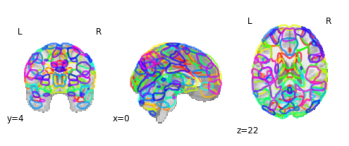

In [40]:
if not os.path.isfile('DiFuMo.png'):
    DiFuMo_fig = plotting.plot_prob_atlas(DiFuMo_maps_list, draw_cross=False, output_file='DiFuMo.png')
    plotting.show()
else:
    DiFuMo_fig = img.imread('DiFuMo.png')
    plt.imshow(DiFuMo_fig)
    plt.axis('off')

**Basal-Ganglia Atlas** by Keuken et al (2015) *doi: https://doi.org/10.1016/j.neuroimage.2014.03.032*

By using the Keuken et al (2015) basal ganglia atlas we included a state-of-the art atlas of the basal ganglia, that fits to the age of our participants.

In [41]:
roi_maps_keuken = []
maps2 = os.listdir('/gxfs_work1/cau/suknp018/atlas/Keuken')
maps = []
for idx in range(len(maps2)):
    if 'resampled' not in maps2[idx] and 'non_linear' in maps2[idx]:
        maps.append(maps2[idx])

Resample the atlas to fit to the DiFuMo-Atlas to be able to use them as combined atlas.

In [42]:
# resample maps
for atlas_map in maps:
    if not os.path.isfile('/gxfs_work1/cau/suknp018/atlas/Keuken/resampled_to_DiFuMo_' + atlas_map):
        atlas_image = load_img('/gxfs_work1/cau/suknp018/atlas/Keuken/' + atlas_map)
        atlas_image = resample_to_img(atlas_image, DiFuMo_maps_list[0]) # resample maps to fit to DiFuMo-Atlas
        atlas_image.to_filename('/gxfs_work1/cau/suknp018/atlas/Keuken/resampled_to_DiFuMo_' + atlas_map)
        roi_maps_keuken.append(atlas_image)
    else:
        atlas_image = load_img('/gxfs_work1/cau/suknp018/atlas/Keuken/resampled_to_DiFuMo_' + atlas_map)
        roi_maps_keuken.append(atlas_image)

Make list with names for Keuken atlas

In [43]:
roi_names_atlas_keuken = []
roi_networks_keuken = []
for atlas_map in maps:
    name = atlas_map[0:5]
    roi_names_atlas_keuken.append(name)
    roi_networks_keuken.append('Basal Ganglia')

# rename to actual names
roi_names_atlas_keuken = ['Globus Palladius internal LH',
                          'Red Nucleus LH', 'Substantia Nigra LH',
                          'Striatium LH', 'Red Nuucleus RH',
                          'Periaqueductal Gray', 'Substantia Nigra RH',
                          'Subthalamic Nucleus LH', 'Subthalamic Nucleus RH',
                          'Globus Palladius external RH', 'Striatium RH',
                          'Globus Palladius external RH', 'Globus Palladius internal RH']

Have a look on the basal ganglia atlas

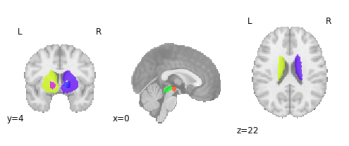

In [44]:
if not os.path.isfile('roi_maps_keuken.png'):
    DiFuMo_fig = plotting.plot_prob_atlas(roi_maps_keuken, draw_cross=False, output_file='roi_maps_keuken.png')
    plotting.show()
else:
    DiFuMo_fig = img.imread('roi_maps_keuken.png')
    plt.imshow(DiFuMo_fig)
    plt.axis('off')

### Combine both Atlasses
To build individual connectomes based on both atlasses combine these.

In [45]:
atlas_maps_combined = DiFuMo_maps_list + roi_maps_keuken  # maps
atlas_labels_combined = DiFuMo_labels + roi_names_atlas_keuken  # names
atlas_networks_combined = DiFuMo_network_labels + roi_networks_keuken  # networks 16 parcellation
atlas_networks_combined_7 = DiFuMo_network_labels_7 + roi_networks_keuken  # networks 7 parcellation


# Save the atlas maps to later load them into the HPC workers.
pickle.dump(atlas_maps_combined,
            open("atlas_maps_combined.pickle",
                 "wb"))
atlasname = 'Keu_DiF_combined'

### Functional connectomes
Compute the individual correlation matrices. Only compute if not already done and only as slurm jobs on HPC (Highly computational demanding! Needs days if done on individual core and/or crashes PC)

While doing this we smooth with fwhm = 5, apply low and high pass filter (.1Hz, .01Hz) as common in resting-state FC analysis.
Don't standardize as we also want to compute individual differences between the timepoints, which would be distorted if standardized in advance

***subjectwise_correlation_matrix*** : Function that computes the subjectwise correlation matrices or loads them into working space if correlation matrix was already computed in advance

In [46]:
def subjectwise_correlation_matrix(df, time, subs, redo):
    print('running')
    atlas = pickle.load(open( "atlas_maps_combined.pickle","rb"))
    atlas_masker = NiftiMapsMasker(maps_img=atlas,
                                   t_r=2,
                                   smoothing_fwhm=5,
                                   low_pass=.1,
                                   high_pass=.01,
                                   memory='nilearn_cache',
                                   verbose=0)  # Make Niftimasker
    for sub in subs:
        path = str(nilearn_dir + '/' +
                   sub + '/ses-' + time +
                   '/' + sub + '_' + pipeline +
                   '_' + atlasname + 
                   '_corrmat-smoothed-nl.tsv')
        # only compute if denoised nifti exists and not already done
        print(sub)
        if not os.path.isfile(path) or redo:
            # first make timeseries for every VOI
            time_series = atlas_masker.fit_transform(df.loc[sub,
                                                            str("Denoised_Images_" +
                                                                pipeline + '_' +
                                                                time)])
            # Choose Correlation Measure
            correlation_measure = ConnectivityMeasure(kind='correlation')
            # Fit Correlation measure to time series of VOIs.
            correlation_matrix = correlation_measure.fit_transform([time_series])[0]
            # Make BIDS-conform folder if not already there
            if not os.path.isdir(str(nilearn_dir + '/' +
                                     sub + '/ses-' + time)):
                os.makedirs(str(nilearn_dir + '/' +
                                sub + '/ses-' + time))
            # Save as .tsv so that in later runs the data can be loaded and does not need to be recomputed again
            correlation_martix = pd.DataFrame(correlation_matrix)
            correlation_martix.to_csv(path, sep='\t')
        elif os.path.isfile(path):  # if already exits load it:
            correlation_matrix = pd.read_csv(path, sep='\t', index_col=0)
        else:
            print('Error')
        return pd.DataFrame(correlation_matrix)

 Compute the correlation matrices using **dask_jobqueue** as this is really computational demanding and takes forever without parallelisation.

In [47]:
timepoint = 'FU3'
dask_jobs_FU3 = []
for sub in df.index:
    sub_df = pd.DataFrame(df.loc[sub, :]).transpose().copy()  # make small sub_df. otherwise memory too high
    dask_jobs_FU3.append(client.submit(subjectwise_correlation_matrix, sub_df,
                                       timepoint,
                                       [sub],
                                       False))

In [48]:
timepoint = 'FU2'
dask_jobs_FU2 = []
for sub in df.index:
    sub_df = pd.DataFrame(df.loc[sub, :]).transpose().copy()  # make small sub_df. otherwise memory too high
    dask_jobs_FU2.append(client.submit(subjectwise_correlation_matrix, sub_df,
                                       timepoint,
                                       [sub],
                                       False))

In [49]:
results_FU3 = client.gather(dask_jobs_FU3)
df.loc[:, str('corrmat_' + pipeline + '_FU3_Keu_DiF_combined')] = results_FU3

In [50]:
results_FU2 = client.gather(dask_jobs_FU2)
df.loc[:, str('corrmat_' + pipeline + '_FU2_Keu_DiF_combined')] = results_FU2

### Difference of functional connectomes

Computes changes in FC between timepoints as the difference between the correlation matrices as:

$$ rsFC(Change) = rsFC(T_2) - rsFC(T_1)$$

In [51]:
# compute difference of correlation matrix 
def difference_of_corr_mats(sub, redo):
    dir_path = str(nilearn_dir + '/' +
                   sub + '/ses-diff')
    path = str(dir_path + '/' + sub + '_' +
               pipeline + '_diff_Keu_DiF_combined_corrmat-smoothed-nl.tsv')
    if not os.path.isfile(path) or redo:   # if not already done earlier
        diffmat = pd.DataFrame(df.loc[sub,
                                      str('corrmat_' + pipeline + '_FU3_Keu_DiF_combined')].to_numpy() - 
                               df.loc[sub,
                                      str('corrmat_' + pipeline + '_FU2_Keu_DiF_combined')].to_numpy())
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        diffmat.to_csv(str(dir_path + '/' + sub + '_' +
                           pipeline +
                           '_diff_Keu_DiF_combined_corrmat-smoothed-nl.tsv'),
                       sep='\t')   # save to file
    else:
        diffmat = pd.read_csv(path, sep='\t', index_col=0)
    return diffmat

In [52]:
diffmats = []
for sub in df.index:
    diffmats.append(difference_of_corr_mats(sub, False))

In [53]:
df.loc[:, str('corrmat_' + pipeline + '_diff_Keu_DiF_combined')] = diffmats

Plot an example

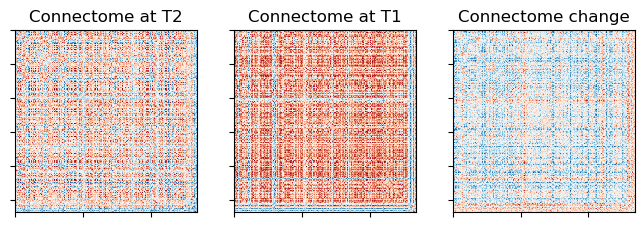

In [54]:
subnumber = 56
diagonal_mask = np.zeros(df.loc[df.index[0],
                   str('corrmat_' + pipeline + '_FU3_Keu_DiF_combined')].shape)
for i in range(diagonal_mask.shape[0]):
    diagonal_mask[i,i] = True


fig, (ax_1, ax_2, ax_3) = plt.subplots(1,
                                       3,
                                       dpi=100,
                                       figsize=(8,
                                                3),
                                       )

plotting.plot_matrix(df.loc[df.index[subnumber],
                   str('corrmat_' + pipeline + '_FU3_Keu_DiF_combined')].replace(1,0),
            cmap=plt.cm.RdBu_r,
            axes=ax_1,
            colorbar=False,
           )
plotting.plot_matrix(df.loc[df.index[subnumber],
                   str('corrmat_' + pipeline + '_FU2_Keu_DiF_combined')].replace(1,0),
            cmap=plt.cm.RdBu_r,
            axes=ax_2,
            colorbar=False
           )
plotting.plot_matrix(df.loc[df.index[subnumber],
                   str('corrmat_' + pipeline + '_diff_Keu_DiF_combined')],
            cmap=plt.cm.RdBu_r,
            axes=ax_3,
            colorbar=False
           )
ax_1.set_title('Connectome at T2')
ax_2.set_title('Connectome at T1')
ax_3.set_title('Connectome change')

fig.savefig(os.path.join(second_dir, 'connectomes.png'))
plt.show()

***
***
## Second-Level-Analysis

### Compute Models
#### Simple Model

$$Age_1 = 19 , Age_2 = 23$$ 

$$Pain/Psychophysical Weakness_{Age} \sim rsFC_{Age} + sex + C$$

***calculate_multiple_regress*** : Function for multiple regression. df is the dataframe used (produced by *make_regress_matrix* , aim_column is the column with Y, confounds are columns to include and len_corr_vector is the length of the flattened correlation matrix of the connectome. 

In [55]:
def calculate_multiple_regress(df, aim_column, confounds, len_corr_vector): 
    pvalues = []
    beta = []
    for col in df.loc[:, :len_corr_vector - 1].columns:
        # prepare subset of df with relevant columns:
        relevant_cols = [aim_column, col] + [confounds]
        df_usage = df.loc[:, relevant_cols]
        df_usage = df_usage.dropna()._get_numeric_data()  # clean data
        # define columns with prerdictor
        X_cols = [col] + [confounds]
        X = np.asarray(df_usage.loc[:, X_cols])
        # add a constant to the data
        X = add_constant(X)
        # calculate model
        model = OLS(endog=np.asarray(df_usage.loc[:, aim_column]),
                    exog=X).fit()
        if len(model.pvalues) != 1:   # if the data is constant no constant is added with 'add_constant'. Important for diagonals of connectivity matrix. Filter these tests out. Otherwise they return errors
            # collect pvalues and beta
            pvalues.append(model.pvalues[1])
            beta.append(model.params[1])
        else:
            pvalues.append(1)
            beta.append(0)
    p_values = np.asarray(pvalues)
    beta = np.asarray(beta)
    return p_values, beta

***make_regress_matrix*** : Function for making regression matrix. timepoint is the timepoint to use, df is the basic df on which the analysis is based. aim_colimn is Y and confounfs are confounds to include. Returns beta and p-values as flattened matrices (according to nilearn sym_matrix_to_vec )

In [56]:
def make_regress_matrix(timepoint, df, aim_column, confounds):
    # prepare Dataframe
    df_connect = []  # empty list to be filled with flattened correlation matrices
    subs = []  # list of subjects
    # compute length of flattened corr matrix
    len_corr_vector = len(sym_matrix_to_vec(df.loc[df.index[5], str('corrmat_' +
                                                                    pipeline +
                                                                    '_FU2_Keu_DiF_combined')].to_numpy()))  # length of vector representing correlation-matrix

    # prepare the correlation matrices by flattening
    for sub in df.index:
        df_connect.append(sym_matrix_to_vec(df.loc[sub, str('corrmat_' +
                                                            pipeline +
                                                            '_' + timepoint +
                                                            '_Keu_DiF_combined')].to_numpy()))
        subs.append(sub)

    # transform to dataFrame
    df_connect = pd.DataFrame(df_connect, index=subs)
    print(str(df_connect.shape[0])+' datasets included')

    # z-scale columnwise - by this we get betas instead of b
    for col in df_connect.columns:
        sd = abs(df_connect.loc[:, col].std())
        mean = df_connect.loc[:, col].mean()
        if not sd < 0.0001:  # leave out constant variables (diagonal of connectivity matrix). Don't need it anyway and just raises errors          
            df_connect.loc[:, col] = (df_connect.loc[:, col]-mean)/sd

    df_connect = pd.concat([df_connect, df], axis=1)  # combine correlation matrices df with dataframe containing psychological data

    # make regression scores:
    p_values, beta = calculate_multiple_regress(df_connect,
                                                aim_column,
                                                confounds,
                                                len_corr_vector)

    return p_values, beta

In [57]:
future_df = client.scatter(df, broadcast=True)  # scatter df beforehand otherwise dask will take forever transferring the df to the workers

Compute using HPC. Could also do this locally but needs quite some CPU and WM.

In [58]:
FU2_analysis = client.submit(make_regress_matrix,
                             'FU2', future_df,
                             'FU2_csi_pain_sum',
                             'sex')

In [59]:
FU3_analysis = client.submit(make_regress_matrix,
                             'FU3', future_df,
                             'FU3_csi_pain_sum',
                             'sex')

#### Advanced Model
$$Pain/Weakness_{23} \sim \Delta(rsFC_{23,19}) + rsFC_{19} + sex + C$$


***make_brain_baseline_controlled_regress_matrix*** : Function for predicting rsFC-change wit pain/weakness score change while controlling for baseline rsFC

In [60]:
def make_brain_baseline_controlled_regress_matrix(df, aim_column):  # function for computation of second level model with rs-fc change as predictor and baseline rs-fc as confound
    # prepare Dataframe
    df_connect_FU2 = []
    df_connect_diff = []
    subs = []
    length_corr_Vector = len(sym_matrix_to_vec(df.loc[df.index[5], str('corrmat_' +
                                                                       pipeline +
                                                                       '_FU2_Keu_DiF_combined')].to_numpy()))
    for sub in df.index:
        df_connect_FU2.append(sym_matrix_to_vec(df.loc[sub, str('corrmat_' +
                                                                pipeline +
                                                                '_FU2_Keu_DiF_combined')].to_numpy()))
        df_connect_diff.append(sym_matrix_to_vec(df.loc[sub, str('corrmat_' +
                                                                 pipeline +
                                                                 '_diff_Keu_DiF_combined')].to_numpy()))
        subs.append(sub)
    df_connect_FU2 = pd.DataFrame(df_connect_FU2, index=subs)
    df_connect_diff = pd.DataFrame(df_connect_diff, index=subs)
    print(str(df_connect_FU2.shape[0])+' datasets included')

    for df_connect in [df_connect_FU2, df_connect_diff]:
        for col in df_connect.columns:
            sd = df_connect.loc[:, col].std()
            mean = df_connect.loc[:, col].mean()
            if not sd < 0.0001:            # filter the diagonal of the connectivity matrix. As these are constants they otherwise result in Errors as division by 0 is performed  
                df_connect.loc[:, col] = (df_connect.loc[:, col] - mean) / sd

    pvalues_FU2 = []
    beta_FU2 = []
    pvalues_diff = []
    beta_diff = []
    models = []

    for col in range(length_corr_Vector):
        df_usage = df.loc[:, aim_column].dropna()._get_numeric_data()
        df_conn = pd.concat([df_connect_FU2[[col]],
                             df_connect_diff[[col]],
                             df['sex']
                            ],
                            axis=1).to_numpy()
        df_conn = add_constant(df_conn)
        model = OLS(endog=df_usage, exog=df_conn).fit()
        if len(model.params) > 3:   # diagonal already has constant column therefore add_constant it does not add one, but the code returns errors if not excluded somehow. That's done by this.
            beta_FU2.append(model.params[1])
            pvalues_FU2.append(model.pvalues[1])
            beta_diff.append(model.params[2])
            pvalues_diff.append(model.pvalues[2])
        else:
            beta_FU2.append(np.nan)
            pvalues_FU2.append(np.nan)
            beta_diff.append(np.nan)
            pvalues_diff.append(np.nan)
        models.append(model)

    return beta_FU2, pvalues_FU2, beta_diff, pvalues_diff #, models

In [61]:
longitudinal_advanced_analysis = client.submit(make_brain_baseline_controlled_regress_matrix,
                           future_df,
                           'FU3_csi_pain_sum')

### Get Results
Get the results, that were computed using the HPC

#### Simple Model

**Follow-up 2**

In [62]:
p_values_FU2_FU2_pain, beta_FU2_FU2_pain = FU2_analysis.result()


In [63]:
FU2_pvalues_df =  pd.DataFrame(vec_to_sym_matrix(p_values_FU2_FU2_pain)).set_axis(atlas_labels_combined).set_axis(atlas_labels_combined, axis=1)
FU2_pvalues_df.to_csv(os.path.join(second_dir,'p_matrix_FU2.txt'))

FU2_beta_df =  pd.DataFrame(vec_to_sym_matrix(beta_FU2_FU2_pain)).set_axis(atlas_labels_combined).set_axis(atlas_labels_combined, axis=1)
FU2_beta_df.to_csv(os.path.join(second_dir,'beta_matrix_FU2.txt'))

**Follow-up 3**

In [64]:
p_values_FU3_FU3_pain, beta_FU3_FU3_pain = FU3_analysis.result()

In [65]:
FU3_pvalues_df =  pd.DataFrame(vec_to_sym_matrix(p_values_FU3_FU3_pain)).set_axis(atlas_labels_combined).set_axis(atlas_labels_combined, axis=1)
FU3_pvalues_df.to_csv(os.path.join(second_dir,'p_matrix_FU2.txt'))

FU3_beta_df =  pd.DataFrame(vec_to_sym_matrix(beta_FU3_FU3_pain)).set_axis(atlas_labels_combined).set_axis(atlas_labels_combined, axis=1)
FU3_beta_df.to_csv(os.path.join(second_dir,'beta_matrix_FU3.txt'))

**Association of both beta maps**

In [66]:
result = OLS(beta_FU3_FU3_pain, add_constant(beta_FU2_FU2_pain)).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     3221.
Date:                Mon, 16 May 2022   Prob (F-statistic):               0.00
Time:                        15:46:07   Log-Likelihood:                 64636.
No. Observations:               36315   AIC:                        -1.293e+05
Df Residuals:                   36313   BIC:                        -1.293e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0291      0.000    134.819      0.000       0.029       0.029
x1             0.3245      0.006     56.756      0.000       0.313       0.336
==============================================================================
Omnibus:                     8476.330   Durbin-Watson:                   1.543
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32797.062
Skew:                          -1.123   Prob(JB):                         0.00
Kurtosis:                       7.078   Cond. No.                         26.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Advanced Model

In [67]:
beta_FU2_on_FU3_base_control, pvalues_FU2_on_FU3_base_control, beta_diff_on_FU3_base_control , pvalues_diff_on_FU3_base_control  = longitudinal_advanced_analysis.result()

In [68]:
longitudinal_diff_pvalues_df =  pd.DataFrame(vec_to_sym_matrix(np.array(pvalues_diff_on_FU3_base_control))).set_axis(atlas_labels_combined).set_axis(atlas_labels_combined, axis=1)
longitudinal_diff_pvalues_df.to_csv(os.path.join(second_dir,'p_matrix_longitudinal_diff.txt'))

longitudinal_diff_pvalues_beta_df =  pd.DataFrame(vec_to_sym_matrix(np.array(beta_diff_on_FU3_base_control))).set_axis(atlas_labels_combined).set_axis(atlas_labels_combined, axis=1)
longitudinal_diff_pvalues_beta_df.to_csv(os.path.join(second_dir,'beta_matrix_longitudinal_diff.txt'))

longitudinal_FU2_pvalues_df =  pd.DataFrame(vec_to_sym_matrix(np.array(pvalues_FU2_on_FU3_base_control))).set_axis(atlas_labels_combined).set_axis(atlas_labels_combined, axis=1)
longitudinal_FU2_pvalues_df.to_csv(os.path.join(second_dir,'p_matrix_longitudinal_FU2.txt'))

longitudinal_FU2_pvalues_beta_df =  pd.DataFrame(vec_to_sym_matrix(np.array(beta_FU2_on_FU3_base_control))).set_axis(atlas_labels_combined).set_axis(atlas_labels_combined, axis=1)
longitudinal_FU2_pvalues_beta_df.to_csv(os.path.join(second_dir,'beta_matrix_longitudinal_FU2.txt'))

In [69]:
cluster.scale(1) # don't need this any longer

***
### Multiple Comparison Correction

Make function to thresholding results using fdr correction

***threshold*** : function to do ROI-wise fdr-correction and return matrices for thresholds

In [70]:
def threshold(p_values, beta):
    p_values = np.array(p_values)
    beta = np.array(beta)

    # transform to np mat
    pvalues_mat = vec_to_sym_matrix(p_values)
    beta_mat = vec_to_sym_matrix(beta)

    pvalues_mat = vec_to_sym_matrix(p_values)
    beta_mat = vec_to_sym_matrix(beta)

    pvalues_df = pd.DataFrame(pvalues_mat)  # make df out of mat
    reject_df = pd.DataFrame(pvalues_mat)  # prepare df to fill with boolean index for rejection of hypothesis 

    for i in pvalues_df.index:  # mask diagonal in p-value matrix as the values don't make any sense
        pvalues_df.iloc[i, i] = 1

    # test for multiple correction roi-wise
    for idx in pvalues_df.index:
        # get p-values of each roi and transform to list
        p_list = pvalues_df.loc[idx, pvalues_df.columns != idx].to_list()   # Leave out cells in diagonal as they do not contain information
        # multiple test correction
        reject, pvals_corrected, _, _ = multipletests(p_list,
                                                      alpha=0.05,
                                                      method='fdr_bh') # correction. Just need reject and pvals_corrected
        pvalues_df.loc[idx, pvalues_df.columns != idx] = pvals_corrected
        reject_df.loc[idx, pvalues_df.columns != idx] = reject
        pvalues_df.loc[idx, idx] = 1  # fill diagnonal with 1 in p-values
        reject_df.loc[idx, idx] = False  # and in reject matrix with False

    # back to np.matrix
    pvalues_mat = pvalues_df.to_numpy()
    reject_mat = reject_df.to_numpy()

    # make nonsymmetric matrix symmetric again
    reject1 = pd.DataFrame(reject_mat).copy().astype(int).to_numpy()
    reject2 = pd.DataFrame(reject_mat).transpose().copy().astype(int).to_numpy()
    reject_mat = (reject1 + reject2) > 0

    return pvalues_mat, reject_mat


***
### Plot Models 

***Prepare Visualization***

The following cells makes lists of labels and networks as well as lists of corresponding colors. These are made in original order as well as ordered by network. 

In [71]:
# Prepare labels and indices to sort RIOs according to its network

# Labels of ROI in variations
DK_labels = atlas_labels_combined.copy()
DK_labels_short = atlas_labels_combined.copy()
DK_network_labels = atlas_networks_combined.copy()
DK_network_labels = pd.Categorical(DK_network_labels).copy()

for idx in range(len(DK_labels)):
    DK_labels[idx] = atlas_labels_combined[idx] + ' ' + str(idx) + ' ' + DK_network_labels.to_list()[idx]
    DK_labels_short[idx] = str(idx+1) + ' ' + atlas_labels_combined[idx]

# Make index for networkwise sorted variant and apply on labels
DK_to_sort = pd.concat([pd.DataFrame(DK_network_labels),
                        pd.DataFrame(atlas_labels_combined)],
                       axis=1).set_axis([0, 1], axis=1)
reorder_networkwise = DK_to_sort.sort_values(by=[0, 1]).index
DK_network_labels_sorted = pd.DataFrame(DK_network_labels).iloc[reorder_networkwise, ]
DK_networks = DK_network_labels.categories
reorder_networkwise = DK_network_labels_sorted.index
DK_labels_sorted = pd.Series(DK_labels)[DK_network_labels_sorted.index]

# Make array representing color for sorted networks
DK_network_colors = DK_network_labels.to_numpy()
Network_description_color = ''
for network, color in zip(DK_networks, ['firebrick', 'bisque',
                                        'navajowhite', 'blanchedalmond',
                                        'steelblue', 'lightsteelblue',
                                        'lightblue', 'seagreen',
                                        'mediumseagreen', 'purple',
                                        'darkmagenta', 'peru',
                                        'thistle', 'plum',
                                        'navy', 'midnightblue',
                                        'mediumturquoise',
                                        'lemonchiffon', 'khaki']):
    DK_network_colors[DK_network_labels == network] = color
    Network_description_color = Network_description_color + ' ' + network + ' has color: ' + color
DK_network_colors_sorted = pd.Series(DK_network_colors)[DK_network_labels_sorted.index].to_list()

# make array that shows boundaries between networks
network_group_boundaries = [0]
for idx in range(256):
    if idx != 0:
        if DK_network_colors_sorted[idx] != DK_network_colors_sorted[idx-1]:
            network_group_boundaries.append(idx)

Find coords for glass brain representation. 

In [72]:
if not os.path.isfile('coords.csv'):
    coords = plotting.find_probabilistic_atlas_cut_coords(atlas_maps_combined)
    pd.DataFrame(coords).to_csv('coords.csv')
else:
    coords = pd.read_csv('coords.csv').set_index('Unnamed: 0').to_numpy()

In [73]:
%matplotlib inline

In [74]:
def plot_matrix(beta_mat, reject_mat, labels_thresholded, max_value):
    
    # make colormap with transparent white to overlay on nonsignificant betas
    color_list = [(0, 0, 0, 0)]
    color_list = color_list + [(1, 1, 1, 0.7)]

    sns.set(font_scale=0.5)
    fig = plt.figure(figsize=(15, 10), dpi=100)
    ax1 = sns.heatmap(beta_mat,
                      cmap=plt.cm.RdBu_r,
                      center=0,
                      square=True,
                      vmin=-max_value,
                      vmax=max_value)
    ax2 = sns.heatmap(pd.DataFrame(reject_mat == False).astype('int'),
                      cmap=color_list,
                      cbar=False, 
                      yticklabels=labels_thresholded, 
                      square=True)
    ax2.set_yticklabels(ax2.get_yticklabels())
    fig.axes.append(ax2)
    fig.axes.append(ax1)
    
#    return fig

In [75]:
def plot_glassbrain(beta_thresholded_filtered_matrix_positiv,beta_thresholded_filtered_matrix_negative, coords_filtered_positive,coords_filtered_negative):
    glassbrain_fig, (ax_pos, ax_neg) = plt.subplots(2, 1, figsize=(15, 10))
    if beta_thresholded_filtered_matrix_positiv.sum() != 0:        
        plotting.plot_connectome(beta_thresholded_filtered_matrix_positiv,
                                 coords_filtered_positive,
                                 axes = ax_pos,
                                 node_size=15,
                                 node_color='gray',
                                 colorbar=False,
                                 edge_cmap=plt.cm.RdBu_r,
                                 display_mode='ortho')
    if beta_thresholded_filtered_matrix_negative.sum() != 0:
        plotting.plot_connectome(beta_thresholded_filtered_matrix_negative,
                                 coords_filtered_negative, node_size=15,
                                 axes=ax_neg,
                                 node_color='gray',
                                 colorbar=False,
                                 edge_cmap=plt.cm.RdBu_r,
                                 display_mode='ortho')
    return glassbrain_fig

In [76]:
def plot_circle(beta_thresholded_mat_sorted, labels_filtered_ordered, DK_labels_sorted, network_group_boundaries, max_value, DK_network_colors_sorted):
    # prepare circular layout with distance between networks
    node_angles = circular_layout(DK_labels_sorted.to_list(),
                                  DK_labels_sorted.to_list(),
                                  start_pos=90,
                                  group_boundaries=network_group_boundaries,
                                  group_sep=1)
    fig = plt.figure(num=None, figsize=(20, 20), dpi=100)
    fig, axes = plot_connectivity_circle(beta_thresholded_mat_sorted,
                                         labels_filtered_ordered,
                                         fig=fig, facecolor='w',
                                         textcolor='k',
                                         interactive=True,
                                         vmin=-max_value,
                                         vmax=max_value,
                                         colormap=plt.cm.RdBu_r,
                                         node_colors=DK_network_colors_sorted,
                                         node_edgecolor='w',
                                         node_angles=node_angles)

    print(Network_description_color)
    return fig

In [77]:
def frequency_of_sig_rsFC_by_rsnetwork(reject_mat, DK_labels):
    reject_df = pd.DataFrame(reject_mat).astype(int)
    reject_df.set_axis(DK_labels, axis = 0, inplace=True)
    number_significant_rsFC = reject_df.sum(axis=1)
    for ROI in reject_df.index:
        if not number_significant_rsFC[ROI] > 10:
            reject_df.drop(ROI, inplace=True)
    reject_df.loc['RS-network', :] = atlas_networks_combined_7
    frequeny_df = reject_df.transpose().groupby('RS-network').mean()

    fig = plt.figure(figsize=(8, 6))
    heatmap_ax = sns.heatmap(frequeny_df,
                vmin=0,
                vmax=1,
                annot=True,
               )
    fig.add_axes(heatmap_ax)
    return frequeny_df


In [78]:
# function for thresholding with multiple testing correction and plotting these
def threshold_and_plot(p_values,
                      beta,
                      timepoint,
                      #df,
                      Y_name,
                      confounds,
                      matrix,
                      glassbrain,
                      circle):

    pvalues_mat, reject_mat = threshold(p_values, beta)

    # make beta matrix
    beta_mat = vec_to_sym_matrix(np.array(beta))

    # make nonsymmetric matrix symmetric again
    # hypothesis get rejected as soon as for one of the two roi for which was roi-wise corrected the hypothesis was rejected.
    reject1 = pd.DataFrame(reject_mat).copy().astype(int).to_numpy()
    reject2 = pd.DataFrame(reject_mat).transpose().copy().astype(int).to_numpy()
    reject_mat = (reject1+reject2) > 0
    
    # make thresholded version of beta-matrix
    beta_thresholded_mat = beta_mat.copy()
    beta_thresholded_mat[reject_mat == False] = 0

    # idx for rois with significant results

    relevant_roi = (pd.DataFrame(reject_mat).astype(int).sum(axis=0) != 0).to_numpy() #at least one
    very_relevant_roi = (pd.DataFrame(reject_mat).astype(int).sum(axis=0) > 3).to_numpy() # at least three

    # compute maximal values for colorbars in graphics
    max_value = np.nanmax(sym_matrix_to_vec(beta_thresholded_mat))
    min_value = abs(np.nanmin(sym_matrix_to_vec(beta_thresholded_mat)))
    if min_value > max_value:
        max_value = min_value

    # threshold labels
    labels_thresholded =[]
    for idx, label in zip(relevant_roi, DK_labels_short):
        if idx:
            labels_thresholded.append(label)
        else:
            labels_thresholded.append('')

    # plot matrix  
    if matrix:
        plot_matrix(beta_mat,
                    reject_mat,
                    labels_thresholded,
                    max_value)

    # filter  
    
    coords_filtered = []
    for idx, coord in zip(relevant_roi, coords):
        if idx is True:
            coords_filtered.append(coord)


    # filter only positive results
    beta_thresholded_filtered_mat_positiv = beta_thresholded_mat.copy()
    beta_thresholded_filtered_mat_positiv[beta_thresholded_filtered_mat_positiv<0] = 0
    
    # filter only negative results
    beta_thresholded_filtered_mat_negative = beta_thresholded_mat.copy()
    beta_thresholded_filtered_mat_negative[beta_thresholded_filtered_mat_negative > 0] = 0

    if beta_thresholded_filtered_mat_positiv.sum() != 0:
        # delete nodes with no positive effects:
        beta_thresholded_filtered_df_positiv = pd.DataFrame(beta_thresholded_filtered_mat_positiv)
        idx = beta_thresholded_filtered_df_positiv.sum(axis=1)  # sum roiwise -> zero if no positive effect 
        idx = (idx != 0)  # make index out of sum-result

        # filter only roi with positive rersults
        beta_thresholded_filtered_df_positiv.set_axis(idx, inplace=True)
        beta_thresholded_filtered_df_positiv.set_axis(idx, axis=1, inplace=True)
        beta_thresholded_filtered_df_positiv = beta_thresholded_filtered_df_positiv.loc[True, True]
        beta_thresholded_filtered_matrix_positiv = beta_thresholded_filtered_df_positiv.to_numpy()

        coords_filtered_positive = np.array(coords)[idx]
    else:
        print('No positive associations')

    if beta_thresholded_filtered_mat_negative.sum() != 0:
        # delete nodes wth no negative results
        beta_thresholded_filtered_df_negative = pd.DataFrame(beta_thresholded_filtered_mat_negative)
        idx = beta_thresholded_filtered_df_negative.sum(axis=1)
        idx = (idx != 0)

        # filter only roi with negative rersults
        beta_thresholded_filtered_df_negative.set_axis(idx, inplace=True)
        beta_thresholded_filtered_df_negative.set_axis(idx, axis=1, inplace=True)
        beta_thresholded_filtered_df_negative = beta_thresholded_filtered_df_negative.loc[True, True]
        beta_thresholded_filtered_matrix_negative = beta_thresholded_filtered_df_negative.to_numpy()

        coords_filtered_negative = np.array(coords)[idx]
    else:
        print('No negative associations')

    if glassbrain:
        glassbrain_fig = plot_glassbrain(beta_thresholded_filtered_matrix_positiv,
                        beta_thresholded_filtered_matrix_negative,
                        coords_filtered_positive,
                        coords_filtered_negative)

        glassbrain_fig.savefig(str(second_dir + '/glassbrain_'+
                timepoint+'_contrast_'+
                Y_name+'_confounds_'+
                ''.join(confounds)+'.svg'))

    # plot connectivity circle

    # nan instead of zero because they are otherwise plotted
    beta_thresholded_mat[beta_thresholded_mat == 0] = np.nan

    # filter labels and sort them networkwise
    labels_filtered_ordered = pd.Series(labels_thresholded)[DK_network_labels_sorted.index].to_list()

    # order beta matrrix networkwise
    beta_thresholded_mat = pd.DataFrame(beta_thresholded_mat)
    beta_thresholded_mat_sorted = beta_thresholded_mat.iloc[reorder_networkwise,
                                                            reorder_networkwise]
    beta_thresholded_mat_sorted = beta_thresholded_mat_sorted.to_numpy()
    
    if circle:
        circle_fig = plot_circle(beta_thresholded_mat_sorted,
                                 labels_filtered_ordered,
                                 DK_labels_sorted,
                                 network_group_boundaries,
                                 max_value,
                                 DK_network_colors_sorted)
        
        circle_fig.savefig(str(second_dir + '/betacircle_'+
                timepoint+'_contrast_'+
                Y_name+'_confounds_'+
                ''.join(confounds)+'.svg'))
    
    # get number of significant rsFC per relevant ROI
    
    number_significant_rsFC = pd.DataFrame(reject_mat).astype(int).sum(axis=0)
    for ROI in number_significant_rsFC.index:
        if number_significant_rsFC[ROI] > 3:
            print('{} has {} sig. associations.'.format(DK_labels_short[ROI],
                                                        number_significant_rsFC[ROI]
                                                        ))
    # and for each analysis 
    number_significant_rsFC_total = number_significant_rsFC.sum()/2
    
    print('In total there are {} sig. associations.'.format(number_significant_rsFC_total))
    
    frequency_df = frequency_of_sig_rsFC_by_rsnetwork(reject_mat, DK_labels)

#### Simple Model

**Age 19**

No positive associations
In total there are 3.0 sig. associations.


/gxfs_home/cau/suknp018/miniconda3/envs/IMAPAIN_env/lib/python3.9/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


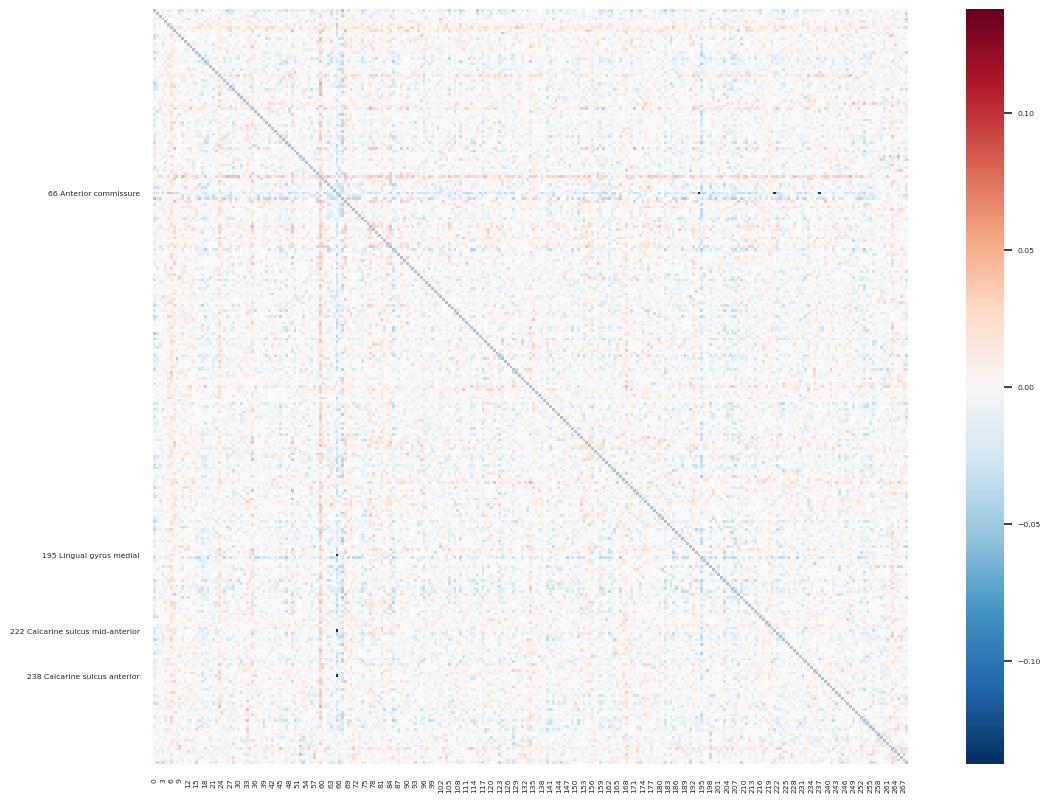

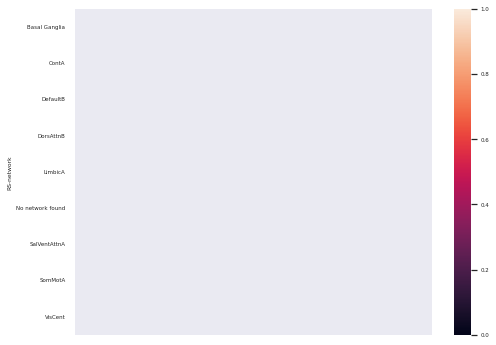

In [79]:
threshold_and_plot(p_values_FU2_FU2_pain,
                  beta_FU2_FU2_pain,
                  'FU2',
                  #df,
                  'FU2_csi_pain_sum',
                  ['sex', '_basic-model'],
                  True,
                  False,
                  False)

***Age 23***

/gxfs_home/cau/suknp018/miniconda3/envs/IMAPAIN_env/lib/python3.9/site-packages/mne_connectivity/viz/circle.py:339: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(sm, ax=axes, use_gridspec=False,


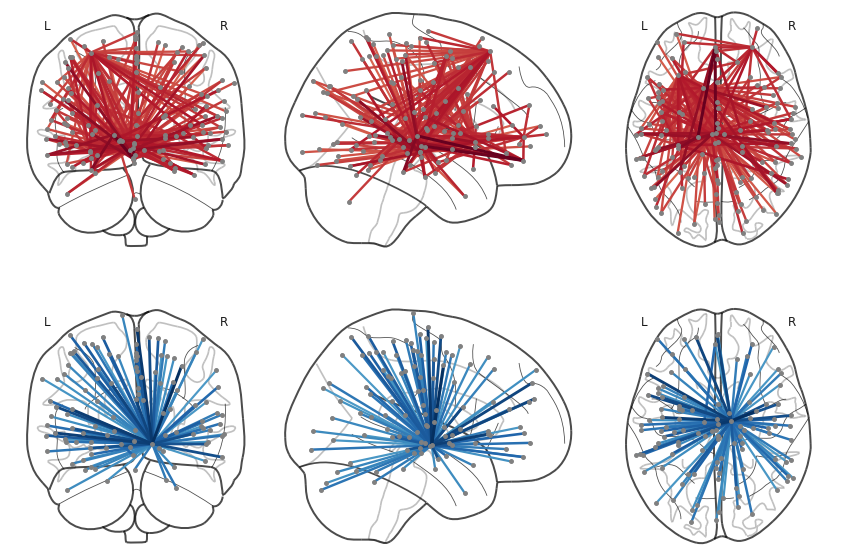

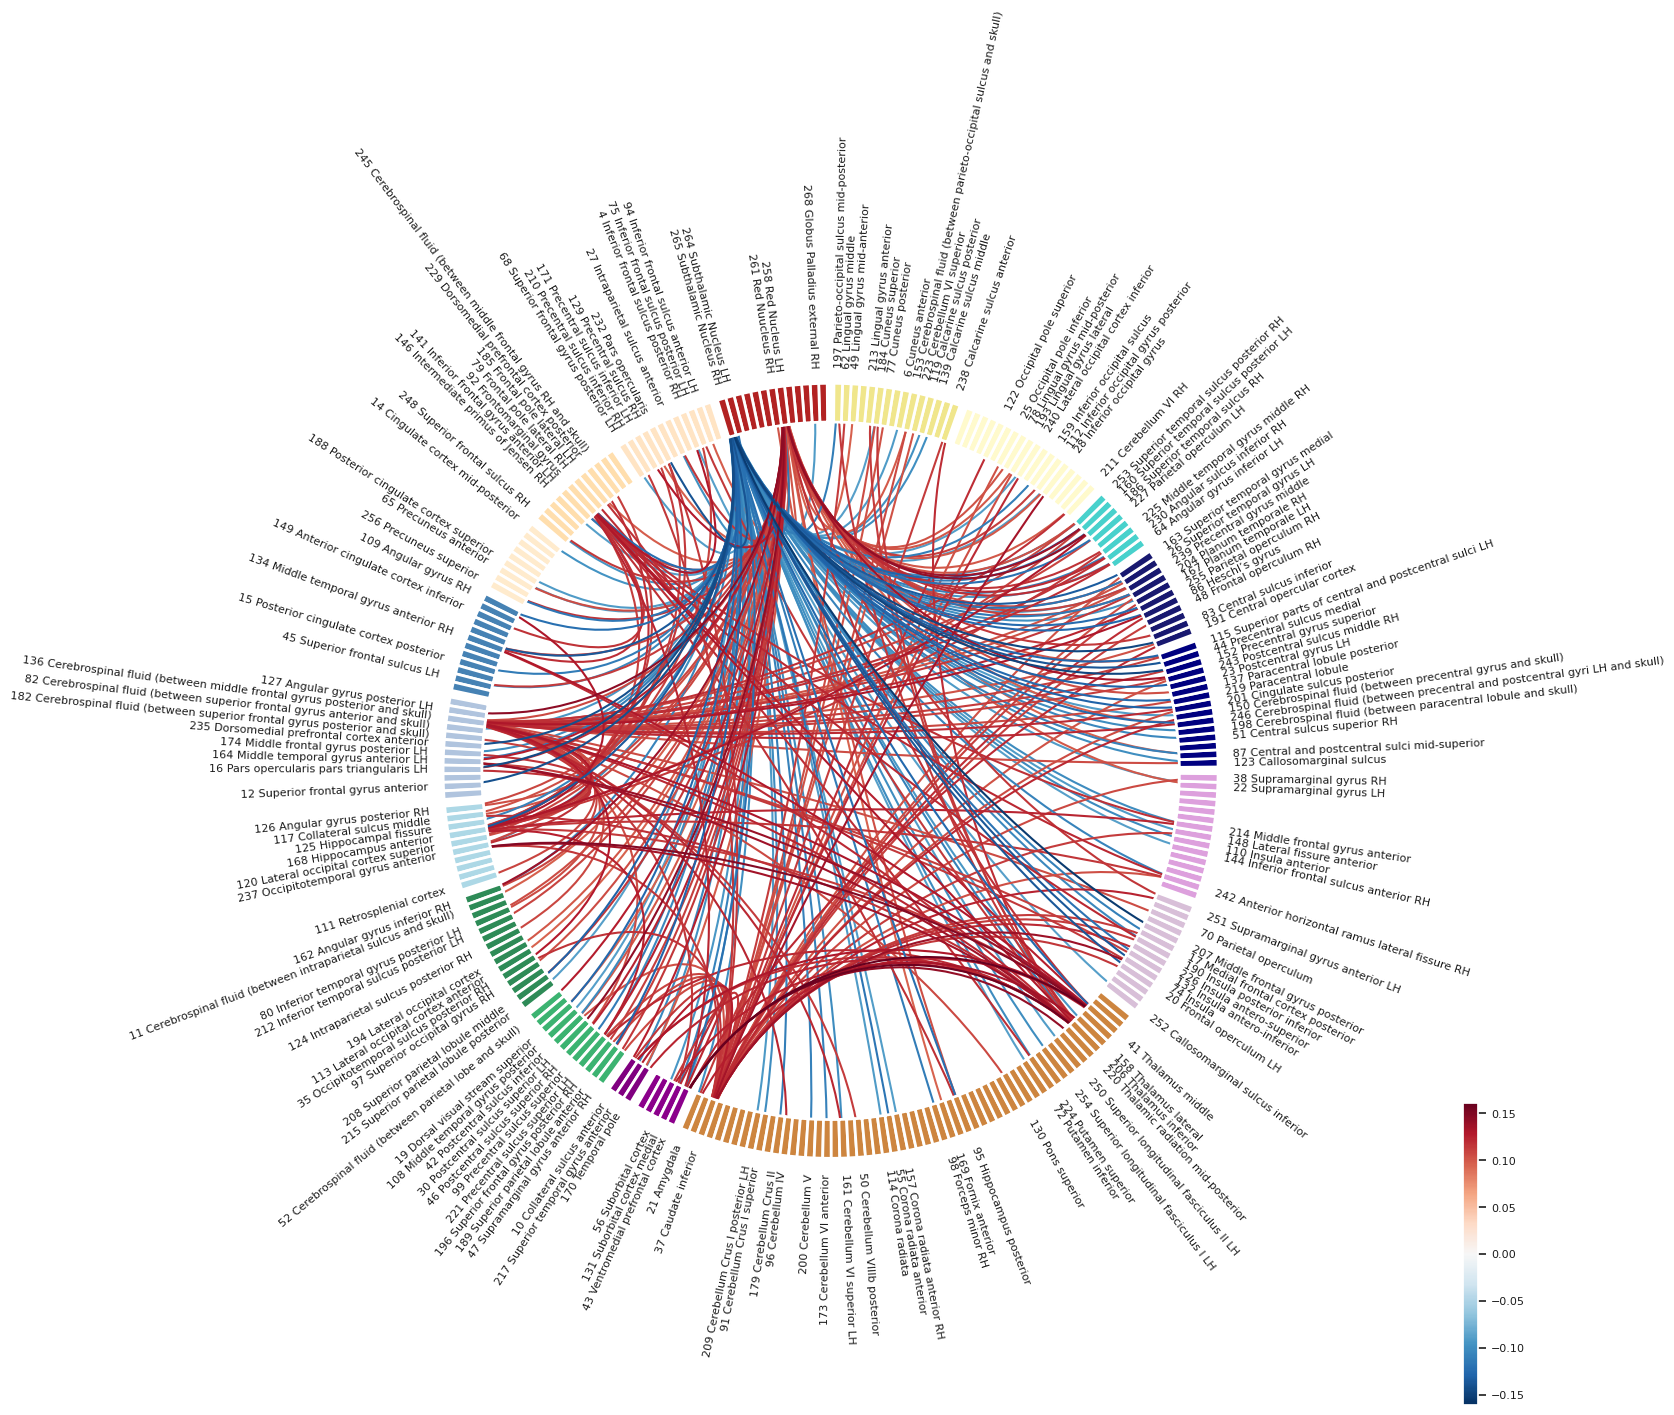

 Basal Ganglia has color: firebrick ContA has color: bisque ContB has color: navajowhite ContC has color: blanchedalmond DefaultA has color: steelblue DefaultB has color: lightsteelblue DefaultC has color: lightblue DorsAttnA has color: seagreen DorsAttnB has color: mediumseagreen LimbicA has color: purple LimbicB has color: darkmagenta No network found has color: peru SalVentAttnA has color: thistle SalVentAttnB has color: plum SomMotA has color: navy SomMotB has color: midnightblue TempPar has color: mediumturquoise VisCent has color: lemonchiffon VisPeri has color: khaki
10 Collateral sulcus anterior has 4 sig. associations.
37 Caudate inferior has 40 sig. associations.
41 Thalamus middle has 11 sig. associations.
43 Ventromedial prefrontal cortex has 9 sig. associations.
92 Frontomarginal gyrus has 15 sig. associations.
134 Middle temporal gyrus anterior RH has 5 sig. associations.
136 Cerebrospinal fluid (between middle frontal gyrus posterior and skull) has 40 sig. associations.


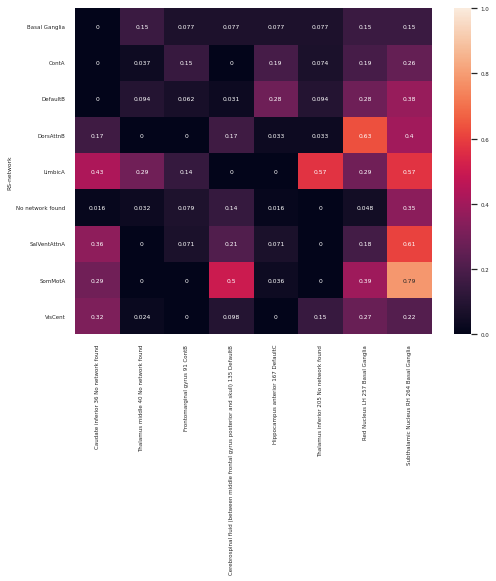

In [80]:
threshold_and_plot(p_values_FU3_FU3_pain,
                  beta_FU3_FU3_pain,
                  'FU3 ',
                  #df,
                  'FU3_csi_pain_sum',
                  ['sex', '_basic-model'],
                  False,
                  True,
                  True)

**Age 19 & 23 comparision**

Plot both ages in one heatmap, seperated by diagonal.

In [81]:
# transform to np
p_values_FU2 = np.array(p_values_FU2_FU2_pain)
beta_FU2 = np.array(beta_FU2_FU2_pain)

p_values_FU3 = np.array(p_values_FU3_FU3_pain)
beta_FU3 = np.array(beta_FU3_FU3_pain)

# transform to np mat
pvalues_mat_FU2 = vec_to_sym_matrix(p_values_FU2)
beta_mat_FU2 = vec_to_sym_matrix(beta_FU2)

pvalues_mat_FU3 = vec_to_sym_matrix(p_values_FU3)
beta_mat_FU3 = vec_to_sym_matrix(beta_FU3)

# ------------- Correct for multiple testing ------------------ #

# FU2
pvalues_df_FU2 = pd.DataFrame(pvalues_mat_FU2)  # make df out of mat
reject_df_FU2 = pd.DataFrame(pvalues_mat_FU2)  # prepare df in correct to fill with boolean index for rejection of hypothesis 
    
pvalues_mat_FU3, reject_mat_FU3  =  threshold(p_values_FU3, beta_FU3)
pvalues_mat_FU2, reject_mat_FU2 = threshold(p_values_FU2, beta_FU2)

pvalues_corrected_FU2 = sym_matrix_to_vec(pvalues_mat_FU2)

# make corresponding vector
reject_FU2 = sym_matrix_to_vec(reject_mat_FU2)

# idx for rois with significant results

relevant_roi_FU2 = (pd.DataFrame(reject_mat_FU2).astype(int).sum(axis=0) != 0).to_numpy()  #at least one
very_relevant_roi_FU2 = (pd.DataFrame(reject_mat_FU2).astype(int).sum(axis=0) > 3).to_numpy()  # at least three

# FU3
pvalues_df_FU3 = pd.DataFrame(pvalues_mat_FU3)  # make df out of mat
reject_df_FU3 = pd.DataFrame(pvalues_mat_FU3)  # prepare df in correct to fill with boolean index for rejection of hypothesis 

# make corresponding vector
reject_FU3 = sym_matrix_to_vec(reject_mat_FU3)

# idx for rois with significant results
relevant_roi_FU3 = (pd.DataFrame(reject_mat_FU3).astype(int).sum(axis=0) != 0).to_numpy()  #at least one
very_relevant_roi_FU3 = (pd.DataFrame(reject_mat_FU3).astype(int).sum(axis=0) > 3).to_numpy()  # at least three -> better for visualization otherwise it's not readable


# prepare matrix

beta_mat_FU2 = pd.DataFrame(beta_mat_FU2)
beta_mat_FU3 = pd.DataFrame(beta_mat_FU3)
reject_mat_FU2 = pd.DataFrame(reject_mat_FU2)
reject_mat_FU3 = pd.DataFrame(reject_mat_FU3)
for idx in beta_mat_FU2.index:
    beta_mat_FU2.loc[idx, idx:] = beta_mat_FU3.loc[idx, idx:]
    reject_mat_FU2.loc[idx, idx:] = reject_mat_FU3.loc[idx, idx:]

# make thresholded aquivalent to compute max value of significant results
beta_thresholded = beta_mat_FU2.copy()
beta_thresholded.to_numpy()[reject_mat_FU2.to_numpy() == False] = 0

# compute maximal values for colorbars in graphics
max_value = np.nanmax(beta_thresholded)
min_value = abs(np.nanmin(beta_thresholded))
if min_value > max_value:
    max_value = min_value

labels_thresholded_FU2 = []
labels_thresholded_FU3 = []
for idx, idx2, label in zip(very_relevant_roi_FU2, very_relevant_roi_FU3, DK_labels_short):
    if idx:
        labels_thresholded_FU2.append(label)
        labels_thresholded_FU3.append('')
    elif idx2:
        labels_thresholded_FU3.append(label)
        labels_thresholded_FU2.append('')
    else:
        labels_thresholded_FU2.append('')
        labels_thresholded_FU3.append('')

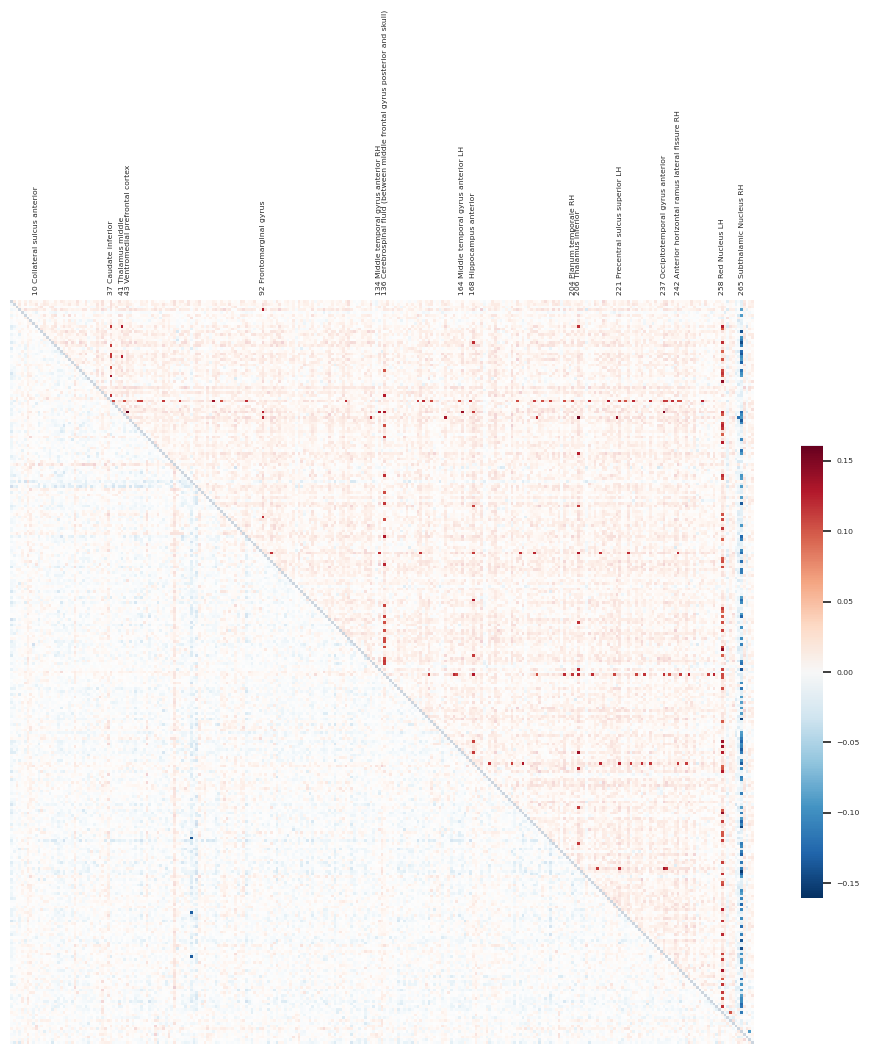

In [82]:
# make colormap with transparent white to overlay for not rejected effects
color_list = [(0, 0, 0, 0)]
color_list = color_list + [(1, 1, 1, c) for c in np.linspace(0.7, 0.8, 100)]
cmapred = colors.LinearSegmentedColormap.from_list('mycmap',
                                                              color_list,
                                                              N=40)

sns.set(font_scale=0.5)
fig = plt.figure(figsize=(12, 12),
                 dpi=100)  # plot some high resolution figure
ax1 = sns.heatmap(beta_mat_FU2,
                  cmap=plt.cm.RdBu_r,
                  center=0, square=True,
                  vmin=-max_value,
                  vmax=max_value,
                  cbar_kws={"shrink": .5})  # add beta heatmap
ax1.xaxis.set_label_position('top')
ax1.xaxis.tick_top()
ax1.tick_params(length=0)
fig.axes.append(ax1)

ax2 = sns.heatmap(pd.DataFrame(reject_mat_FU2 == False).astype('int'),
                  cmap=color_list,
                  vmax=0.05,
                  cbar=False,
                  yticklabels=labels_thresholded_FU2,
                  xticklabels=labels_thresholded_FU3,
                  square=True)  # overlay non significant effects with white transparent colour
ax2.xaxis.tick_top()
ax2.tick_params(length=0)
ax2.xaxis.set_label_position('top')
fig.axes.append(ax2)


fig.savefig(str('/gxfs_work1/cau/suknp018/My_Data/IMAGEN/data/derivatives/nilearn/SecondLevel/heatmap_comparison.svg'))

#### Advanced Model

Model with effects on **Pain/Weakness** by *Brain Connectivity Changes* (23-19) controlled by *Baseline Brain Connectivity* (19) and *Sex*.

$$ Pain/Weakness(23) \sim rsFC(23-19) + rsFC(19) + sex + c $$

**Brain Reorganisation** (FU3-FU2)

/gxfs_home/cau/suknp018/miniconda3/envs/IMAPAIN_env/lib/python3.9/site-packages/mne_connectivity/viz/circle.py:339: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(sm, ax=axes, use_gridspec=False,


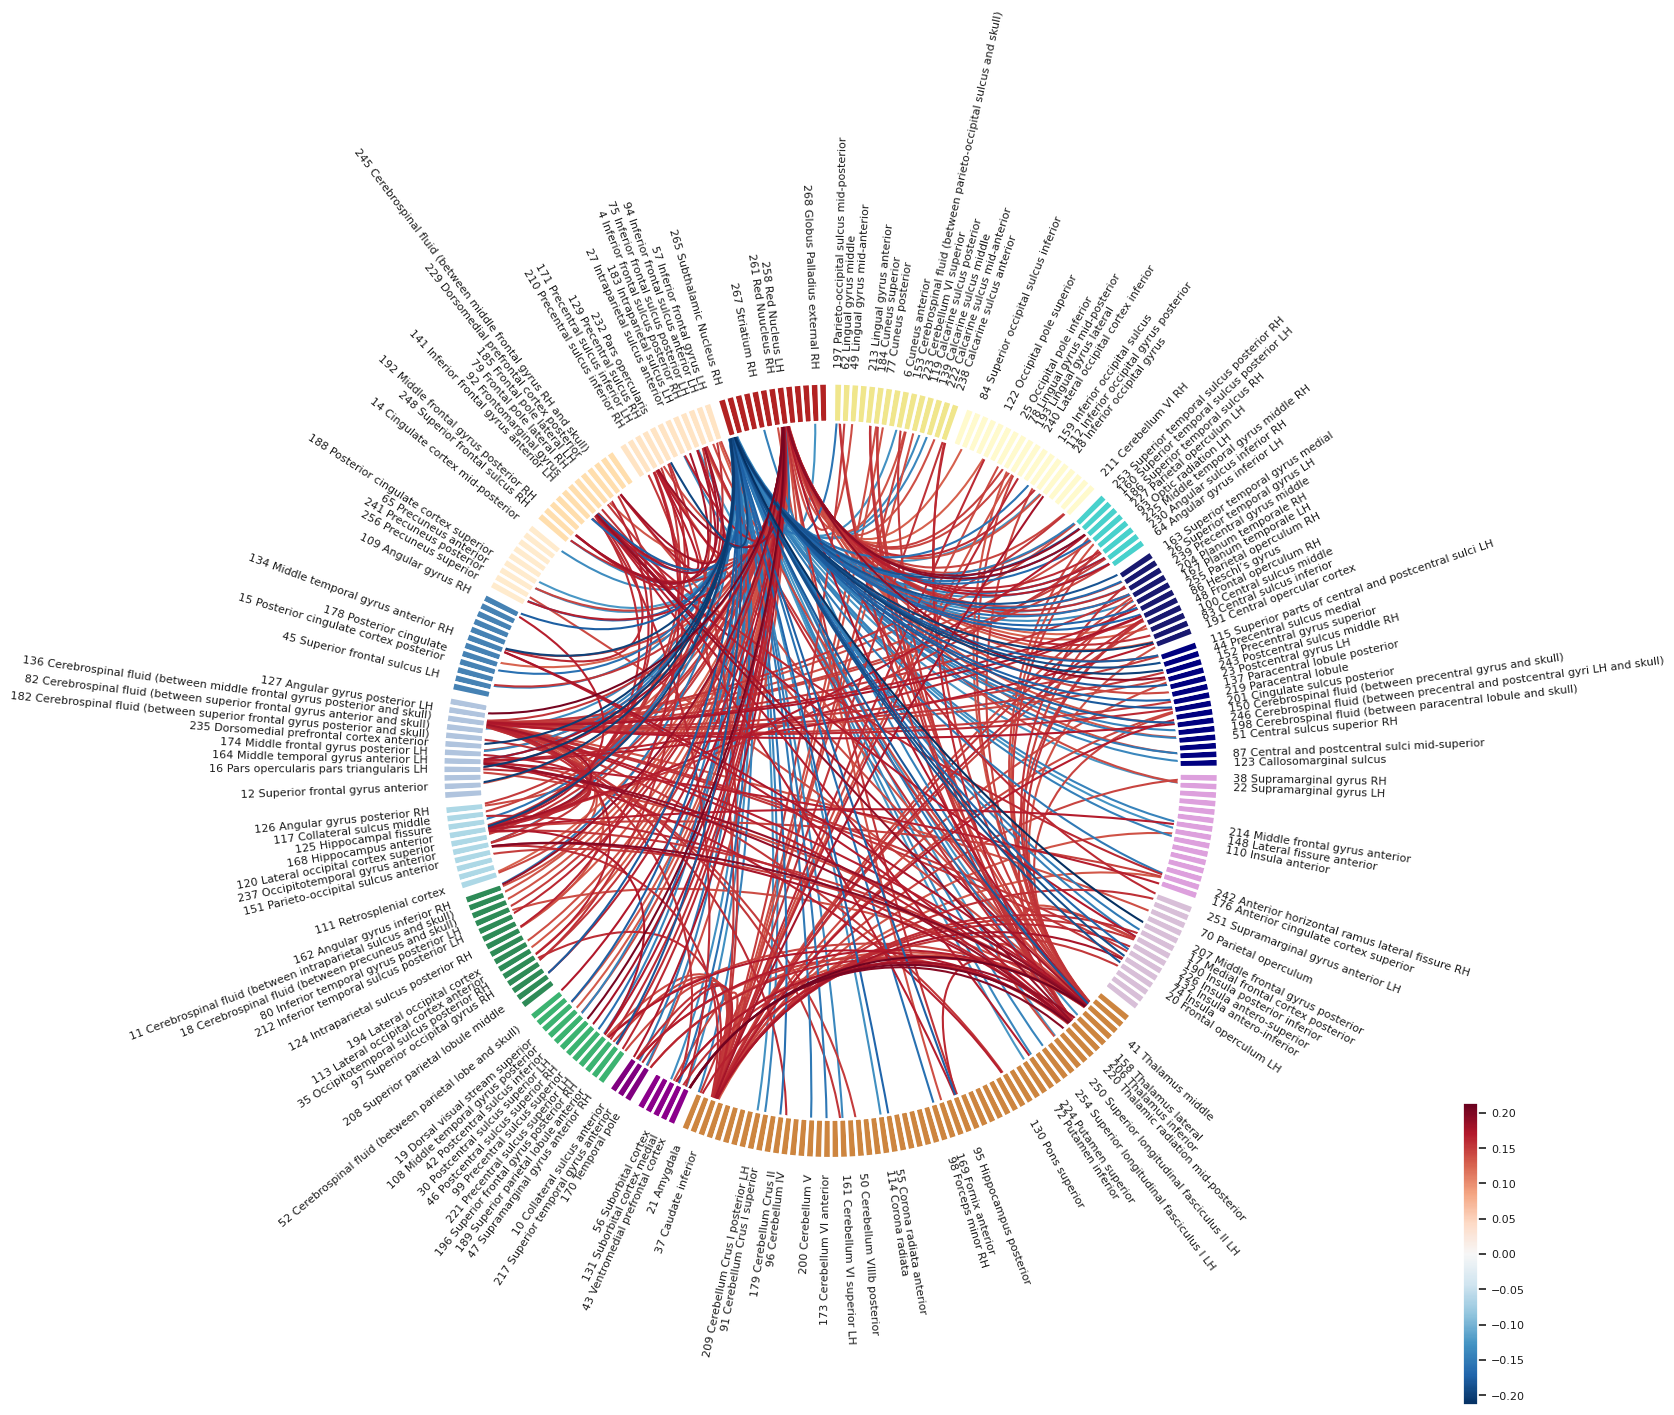

 Basal Ganglia has color: firebrick ContA has color: bisque ContB has color: navajowhite ContC has color: blanchedalmond DefaultA has color: steelblue DefaultB has color: lightsteelblue DefaultC has color: lightblue DorsAttnA has color: seagreen DorsAttnB has color: mediumseagreen LimbicA has color: purple LimbicB has color: darkmagenta No network found has color: peru SalVentAttnA has color: thistle SalVentAttnB has color: plum SomMotA has color: navy SomMotB has color: midnightblue TempPar has color: mediumturquoise VisCent has color: lemonchiffon VisPeri has color: khaki
10 Collateral sulcus anterior has 4 sig. associations.
16 Pars opercularis pars triangularis LH has 4 sig. associations.
37 Caudate inferior has 38 sig. associations.
41 Thalamus middle has 42 sig. associations.
43 Ventromedial prefrontal cortex has 6 sig. associations.
56 Suborbital cortex has 4 sig. associations.
75 Inferior frontal sulcus posterior LH has 6 sig. associations.
86 Heschl’s gyrus has 6 sig. associat

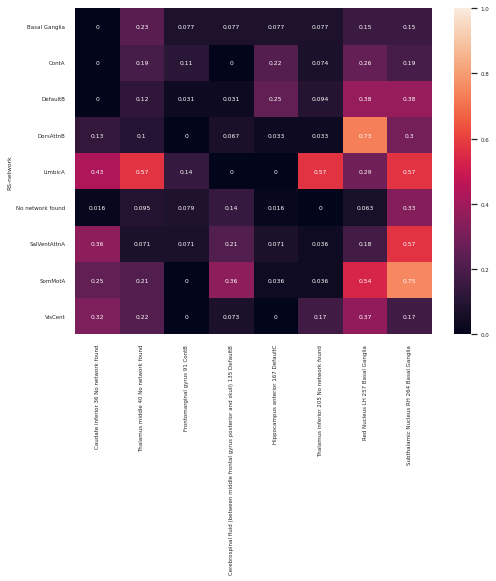

In [83]:
threshold_and_plot(pvalues_diff_on_FU3_base_control,
                   beta_diff_on_FU3_base_control,
                   'diff ',
                   'FU3_csi_pain_sum',
                   ['sex', '_advanced-model'],
                   False,
                   False,
                   True)

**FU2 Brain Organisation**

/gxfs_home/cau/suknp018/miniconda3/envs/IMAPAIN_env/lib/python3.9/site-packages/mne_connectivity/viz/circle.py:339: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(sm, ax=axes, use_gridspec=False,


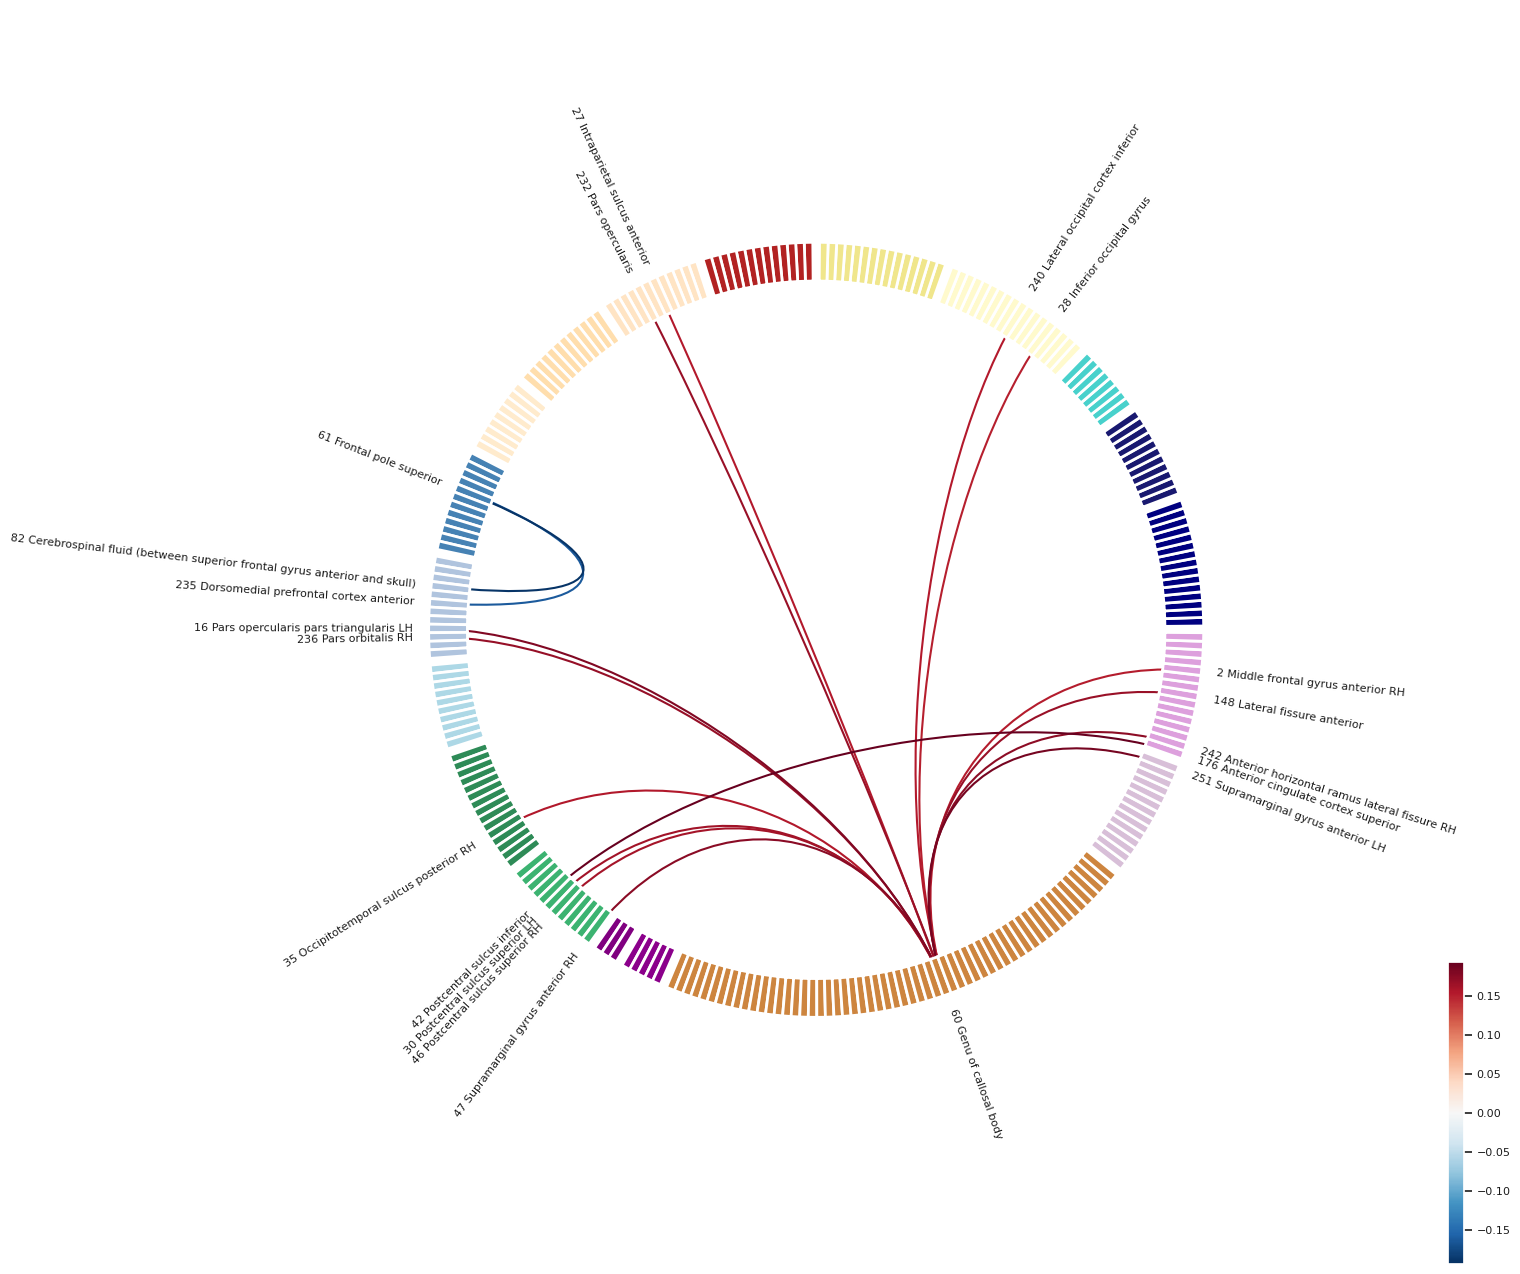

 Basal Ganglia has color: firebrick ContA has color: bisque ContB has color: navajowhite ContC has color: blanchedalmond DefaultA has color: steelblue DefaultB has color: lightsteelblue DefaultC has color: lightblue DorsAttnA has color: seagreen DorsAttnB has color: mediumseagreen LimbicA has color: purple LimbicB has color: darkmagenta No network found has color: peru SalVentAttnA has color: thistle SalVentAttnB has color: plum SomMotA has color: navy SomMotB has color: midnightblue TempPar has color: mediumturquoise VisCent has color: lemonchiffon VisPeri has color: khaki
60 Genu of callosal body has 14 sig. associations.
In total there are 17.0 sig. associations.


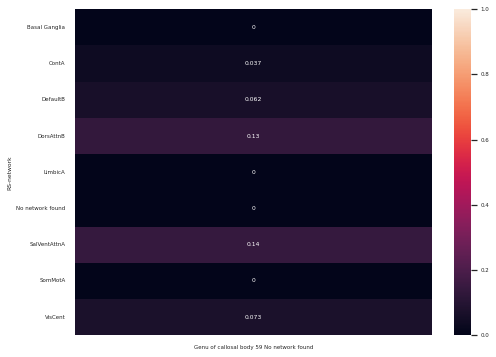

In [84]:
threshold_and_plot(pvalues_FU2_on_FU3_base_control,
                   beta_FU2_on_FU3_base_control,
                   'diff ',
                   'FU3_csi_pain_sum',
                   ['sex', '_advanced-model'],
                   False,
                   False,
                   True)

Plot connectivity hubs 

Subthalamic Nucleus RH
Red Nucleus LH
Hippocampus anterior
Caudate inferior
Thalamus middle
Thalamus inferior


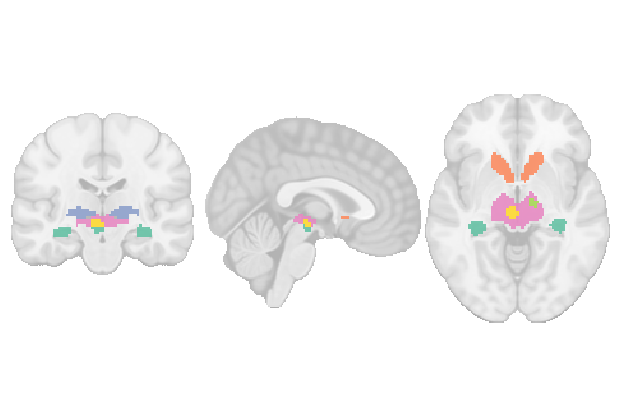

In [85]:
threshold_image_arrays = []
roi_numbers = [264, 257, 167, 36, 40, 205,]

for position, i in zip(roi_numbers, range(1,len(roi_numbers)+1)):
    image_roi_prob = atlas_maps_combined[position].get_fdata()
    threshold_image_arrays.append((image_roi_prob > np.mean(image_roi_prob[image_roi_prob != 0])+0.00000001)*i)
    print(atlas_labels_combined[position])
    ROI = new_img_like(atlas_maps_combined[0],threshold_image_arrays[i-1])
#    plotting.plot_roi(ROI,
#                  draw_cross = False,
 #                    )
    
ROI_s = new_img_like(atlas_maps_combined[0], np.array(threshold_image_arrays).sum(axis=0))

figure_ROIs = plt.figure(
                         dpi=100
                        )
plotting.plot_roi(ROI_s,
                  draw_cross = False,
                  display_mode='ortho',
                  figure=figure_ROIs,
                  bg_img=load_mni152_template(resolution=1),
                  black_bg=False,
                  dim=2,
                  resampling_interpolation='continious',
                  annotate=False,
                  cmap='Set2',
                  alpha=.9,
                  linewidths=.4,
                 )
figure_ROIs.savefig('ROIs_noticable.svg')

## Post-hoc-analysis

Effects of cortical Integration of the Subthalamic Nuclei on **pain/psychophysical weakness**

In [86]:
# Compute mean cortical rs-FC of both STN to the DiFuMo

df_mean_conn = df.copy()

# prepare Dataframe
for timepoint in ['FU2', 'diff', 'FU3']:
    mean_connectivities = []
    len_corr_vector = len(sym_matrix_to_vec(df.loc[df.index[5], str('corrmat_' +
                                                                    pipeline +
                                                                    '_FU2_Keu_DiF_combined')].to_numpy()))-1  # length of vector representing correlation-matrix
    for sub in df.index:
        sub_conn_matrix = df.loc[sub, str('corrmat_' + pipeline +
                                          '_' + timepoint +
                                          '_Keu_DiF_combined')] 
        sub_conn_matrix.set_axis(DK_labels, axis=0, inplace=True)
        sub_conn_matrix.set_axis(DK_labels, axis=1, inplace=True)
        mean_conn_L = sub_conn_matrix.loc[:sub_conn_matrix.index[255],
                                          'Subthalamic Nucleus LH 263 Basal Ganglia'].mean()  # compute Mean connectivity of  STN_L with cortical noedes (exclude itself and other ROi from Keuken (2015))
        mean_conn_R = sub_conn_matrix.loc[:sub_conn_matrix.index[255],
                                          'Subthalamic Nucleus RH 264 Basal Ganglia'].mean()  # Same for right
        mean_conn = (mean_conn_L + mean_conn_R)/2  # mean of both 
        mean_connectivities.append(mean_conn)  # put in list

    mean_connectivities_scaled = (np.array(mean_connectivities)-np.array(mean_connectivities).mean()) / np.array(mean_connectivities).std()  # z-scale
    mean_connectivities = pd.DataFrame(mean_connectivities_scaled).set_index(df.index).set_axis([str('mean_cort_conn_STN_' + timepoint)], axis=1)  # put to df

    # combine with big data frame
    df_mean_conn = pd.concat([mean_connectivities, df_mean_conn], axis=1) 
    df_mean_conn = add_constant(df_mean_conn)

model = OLS(endog=df_mean_conn.loc[:, ['FU3_csi_pain_sum']],
            exog=df_mean_conn.loc[:, ['mean_cort_conn_STN_diff',
                                      'mean_cort_conn_STN_FU2',
                                      'sex',
                                      'const']]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       FU3_csi_pain_sum   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     8.198
Date:                Mon, 16 May 2022   Prob (F-statistic):           2.29e-05
Time:                        15:49:01   Log-Likelihood:                -966.92
No. Observations:                 690   AIC:                             1942.
Df Residuals:                     686   BIC:                             1960.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
mean_cort_conn_STN_diff    -0.1797      0.051     -3.514      0.000      -0.280      -0.079
mean_cort_conn_STN_FU2     -0.0744      0.051     -1.454      0.146      -0.175       0.026
sex                        -0.2414      0.076     -3.173      0.002      -0.391      -0.092
const                       0.1018      0.049      2.062      0.040       0.005       0.199
==============================================================================
Omnibus:                      466.844   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5098.844
Skew:                           2.987   Prob(JB):                         0.00
Kurtosis:                      14.902   Cond. No.                         2.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Plot the results in a 3D-model

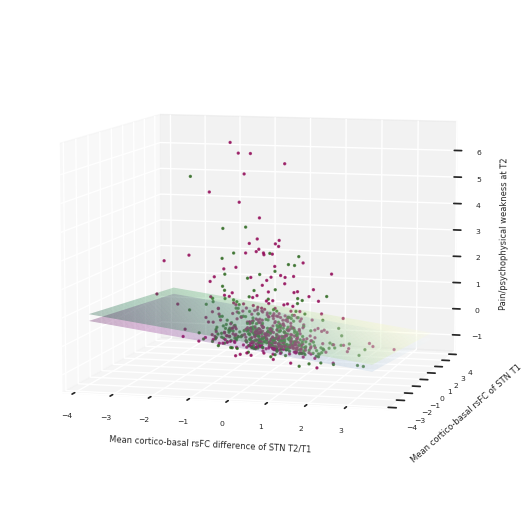

In [87]:
cmap = colors.ListedColormap(['black'])


fig = plt.figure(figsize=(5, 5), dpi=100, facecolor='white')
ax = Axes3D(fig, auto_add_to_figure=False)
ax.set_zlabel('Pain/psychophysical weakness at T2')
ax.set_ylabel('Mean cortico-basal rsFC of STN T1')
ax.set_xlabel('Mean cortico-basal rsFC difference of STN T2/T1')
ax.set_facecolor('None')

sequence_containing_x_vals = df_mean_conn.loc[:, ['mean_cort_conn_STN_diff']]
sequence_containing_y_vals = df_mean_conn.loc[:, ['mean_cort_conn_STN_FU2']]
sequence_containing_z_vals = df_mean_conn.loc[:, ['FU3_csi_pain_sum']]
# plot regression
x_surf, y_surf = np.meshgrid(np.linspace(sequence_containing_x_vals.min(),
                                         sequence_containing_x_vals.max(), 1000),
                             np.linspace(sequence_containing_y_vals.min(),
                                         sequence_containing_y_vals.max(), 1000 )
                                        )
onlyX = pd.DataFrame({'mean_cort_conn_STN_diff': x_surf.ravel(),
                      'mean_cort_conn_STN_FU2': y_surf.ravel()})

# make model with reduced dimensionality to plot
model2 = OLS(endog=df_mean_conn.loc[:, ['FU3_csi_pain_sum']],
            exog=df_mean_conn.loc[:, ['mean_cort_conn_STN_diff',
                                      'mean_cort_conn_STN_FU2',]]).fit()
# copy results from high dimensionality model to plottable model 
model2.params[0] = model.params[0]
model2.params[1] = model.params[1]


fittedY = model2.predict(exog=onlyX)

ax.plot_surface(x_surf,
                y_surf,
                np.array(fittedY + model.params[3]).reshape(x_surf.shape),
                alpha=0.3,
                cmap=cm.YlGn,
                edgecolor='none')

ax.plot_surface(x_surf,
                y_surf,
                np.array(fittedY + model.params[3] + model.params[2]).reshape(x_surf.shape),
                alpha=0.3,
                cmap=cm.BuPu,
                edgecolor='none')

# plot Scatterplot
ax.scatter(sequence_containing_x_vals,
           sequence_containing_y_vals,
           sequence_containing_z_vals,
           c=df_mean_conn.loc[:, ['sex']],
           s=2,
           cmap=plt.cm.PiYG,
           alpha=0.7,
           edgecolors = None
          )
ax.view_init(8, 285)
fig.add_axes(ax)
fig.savefig(os.path.join(second_dir, 'posthoch_regression_3D.png'))
plt.show()

In [88]:
client.close()
cluster.close()

***
## Supplemantary Material

***

### fmriPrep

Results included in this manuscript come from preprocessing performed using fMRIPrep 20.2.3 (Esteban, Markiewicz, et al. (2018); Esteban, Blair, et al. (2018); RRID:SCR_016216), which is based on Nipype 1.6.1 (Gorgolewski et al. (2011); Gorgolewski et al. (2018); RRID:SCR_002502).

Anatomical data preprocessing

    A total of 1 T1-weighted (T1w) images were found within the input BIDS dataset.The T1-weighted (T1w) image was corrected for intensity non-uniformity (INU) with N4BiasFieldCorrection (Tustison et al. 2010), distributed with ANTs 2.3.3 (Avants et al. 2008, RRID:SCR_004757), and used as T1w-reference throughout the workflow. The T1w-reference was then skull-stripped with a Nipype implementation of the antsBrainExtraction.sh workflow (from ANTs), using OASIS30ANTs as target template. Brain tissue segmentation of cerebrospinal fluid (CSF), white-matter (WM) and gray-matter (GM) was performed on the brain-extracted T1w using fast (FSL 5.0.9, RRID:SCR_002823, Zhang, Brady, and Smith 2001). Brain surfaces were reconstructed using recon-all (FreeSurfer 6.0.1, RRID:SCR_001847, Dale, Fischl, and Sereno 1999), and the brain mask estimated previously was refined with a custom variation of the method to reconcile ANTs-derived and FreeSurfer-derived segmentations of the cortical gray-matter of Mindboggle (RRID:SCR_002438, Klein et al. 2017). Volume-based spatial normalization to two standard spaces (MNI152NLin2009cAsym, MNI152NLin6Asym) was performed through nonlinear registration with antsRegistration (ANTs 2.3.3), using brain-extracted versions of both T1w reference and the T1w template. The following templates were selected for spatial normalization: ICBM 152 Nonlinear Asymmetrical template version 2009c [Fonov et al. (2009), RRID:SCR_008796; TemplateFlow ID: MNI152NLin2009cAsym], FSL’s MNI ICBM 152 non-linear 6th Generation Asymmetric Average Brain Stereotaxic Registration Model [Evans et al. (2012), RRID:SCR_002823; TemplateFlow ID: MNI152NLin6Asym],
Functional data preprocessing

    For each of the 1 BOLD runs found per subject (across all tasks and sessions), the following preprocessing was performed. First, a reference volume and its skull-stripped version were generated using a custom methodology of fMRIPrep. Susceptibility distortion correction (SDC) was omitted. The BOLD reference was then co-registered to the T1w reference using bbregister (FreeSurfer) which implements boundary-based registration (Greve and Fischl 2009). Co-registration was configured with six degrees of freedom. Head-motion parameters with respect to the BOLD reference (transformation matrices, and six corresponding rotation and translation parameters) are estimated before any spatiotemporal filtering using mcflirt (FSL 5.0.9, Jenkinson et al. 2002). The BOLD time-series (including slice-timing correction when applied) were resampled onto their original, native space by applying the transforms to correct for head-motion. These resampled BOLD time-series will be referred to as preprocessed BOLD in original space, or just preprocessed BOLD. The BOLD time-series were resampled into standard space, generating a preprocessed BOLD run in MNI152NLin2009cAsym space. First, a reference volume and its skull-stripped version were generated using a custom methodology of fMRIPrep. Automatic removal of motion artifacts using independent component analysis (ICA-AROMA, Pruim et al. 2015) was performed on the preprocessed BOLD on MNI space time-series after removal of non-steady state volumes and spatial smoothing with an isotropic, Gaussian kernel of 6mm FWHM (full-width half-maximum). Corresponding “non-aggresively” denoised runs were produced after such smoothing. Additionally, the “aggressive” noise-regressors were collected and placed in the corresponding confounds file. Several confounding time-series were calculated based on the preprocessed BOLD: framewise displacement (FD), DVARS and three region-wise global signals. FD was computed using two formulations following Power (absolute sum of relative motions, Power et al. (2014)) and Jenkinson (relative root mean square displacement between affines, Jenkinson et al. (2002)). FD and DVARS are calculated for each functional run, both using their implementations in Nipype (following the definitions by Power et al. 2014). The three global signals are extracted within the CSF, the WM, and the whole-brain masks. Additionally, a set of physiological regressors were extracted to allow for component-based noise correction (CompCor, Behzadi et al. 2007). Principal components are estimated after high-pass filtering the preprocessed BOLD time-series (using a discrete cosine filter with 128s cut-off) for the two CompCor variants: temporal (tCompCor) and anatomical (aCompCor). tCompCor components are then calculated from the top 2% variable voxels within the brain mask. For aCompCor, three probabilistic masks (CSF, WM and combined CSF+WM) are generated in anatomical space. The implementation differs from that of Behzadi et al. in that instead of eroding the masks by 2 pixels on BOLD space, the aCompCor masks are subtracted a mask of pixels that likely contain a volume fraction of GM. This mask is obtained by dilating a GM mask extracted from the FreeSurfer’s aseg segmentation, and it ensures components are not extracted from voxels containing a minimal fraction of GM. Finally, these masks are resampled into BOLD space and binarized by thresholding at 0.99 (as in the original implementation). Components are also calculated separately within the WM and CSF masks. For each CompCor decomposition, the k components with the largest singular values are retained, such that the retained components’ time series are sufficient to explain 50 percent of variance across the nuisance mask (CSF, WM, combined, or temporal). The remaining components are dropped from consideration. The head-motion estimates calculated in the correction step were also placed within the corresponding confounds file. The confound time series derived from head motion estimates and global signals were expanded with the inclusion of temporal derivatives and quadratic terms for each (Satterthwaite et al. 2013). Frames that exceeded a threshold of 0.5 mm FD or 1.5 standardised DVARS were annotated as motion outliers. All resamplings can be performed with a single interpolation step by composing all the pertinent transformations (i.e. head-motion transform matrices, susceptibility distortion correction when available, and co-registrations to anatomical and output spaces). Gridded (volumetric) resamplings were performed using antsApplyTransforms (ANTs), configured with Lanczos interpolation to minimize the smoothing effects of other kernels (Lanczos 1964). Non-gridded (surface) resamplings were performed using mri_vol2surf (FreeSurfer).

Many internal operations of fMRIPrep use Nilearn 0.6.2 (Abraham et al. 2014, RRID:SCR_001362), mostly within the functional processing workflow. For more details of the pipeline, see the section corresponding to workflows in fMRIPrep’s documentation.
Copyright Waiver

The above boilerplate text was automatically generated by fMRIPrep with the express intention that users should copy and paste this text into their manuscripts unchanged. It is released under the CC0 license.
References

Abraham, Alexandre, Fabian Pedregosa, Michael Eickenberg, Philippe Gervais, Andreas Mueller, Jean Kossaifi, Alexandre Gramfort, Bertrand Thirion, and Gael Varoquaux. 2014. “Machine Learning for Neuroimaging with Scikit-Learn.” Frontiers in Neuroinformatics 8. https://doi.org/10.3389/fninf.2014.00014.

Avants, B.B., C.L. Epstein, M. Grossman, and J.C. Gee. 2008. “Symmetric Diffeomorphic Image Registration with Cross-Correlation: Evaluating Automated Labeling of Elderly and Neurodegenerative Brain.” Medical Image Analysis 12 (1): 26–41. https://doi.org/10.1016/j.media.2007.06.004.

Behzadi, Yashar, Khaled Restom, Joy Liau, and Thomas T. Liu. 2007. “A Component Based Noise Correction Method (CompCor) for BOLD and Perfusion Based fMRI.” NeuroImage 37 (1): 90–101. https://doi.org/10.1016/j.neuroimage.2007.04.042.

Dale, Anders M., Bruce Fischl, and Martin I. Sereno. 1999. “Cortical Surface-Based Analysis: I. Segmentation and Surface Reconstruction.” NeuroImage 9 (2): 179–94. https://doi.org/10.1006/nimg.1998.0395.

Esteban, Oscar, Ross Blair, Christopher J. Markiewicz, Shoshana L. Berleant, Craig Moodie, Feilong Ma, Ayse Ilkay Isik, et al. 2018. “FMRIPrep.” Software. Zenodo. https://doi.org/10.5281/zenodo.852659.

Esteban, Oscar, Christopher Markiewicz, Ross W Blair, Craig Moodie, Ayse Ilkay Isik, Asier Erramuzpe Aliaga, James Kent, et al. 2018. “fMRIPrep: A Robust Preprocessing Pipeline for Functional MRI.” Nature Methods. https://doi.org/10.1038/s41592-018-0235-4.

Evans, AC, AL Janke, DL Collins, and S Baillet. 2012. “Brain Templates and Atlases.” NeuroImage 62 (2): 911–22. https://doi.org/10.1016/j.neuroimage.2012.01.024.

Fonov, VS, AC Evans, RC McKinstry, CR Almli, and DL Collins. 2009. “Unbiased Nonlinear Average Age-Appropriate Brain Templates from Birth to Adulthood.” NeuroImage 47, Supplement 1: S102. https://doi.org/10.1016/S1053-8119(09)70884-5.

Gorgolewski, K., C. D. Burns, C. Madison, D. Clark, Y. O. Halchenko, M. L. Waskom, and S. Ghosh. 2011. “Nipype: A Flexible, Lightweight and Extensible Neuroimaging Data Processing Framework in Python.” Frontiers in Neuroinformatics 5: 13. https://doi.org/10.3389/fninf.2011.00013.

Gorgolewski, Krzysztof J., Oscar Esteban, Christopher J. Markiewicz, Erik Ziegler, David Gage Ellis, Michael Philipp Notter, Dorota Jarecka, et al. 2018. “Nipype.” Software. Zenodo. https://doi.org/10.5281/zenodo.596855.

Greve, Douglas N, and Bruce Fischl. 2009. “Accurate and Robust Brain Image Alignment Using Boundary-Based Registration.” NeuroImage 48 (1): 63–72. https://doi.org/10.1016/j.neuroimage.2009.06.060.

Jenkinson, Mark, Peter Bannister, Michael Brady, and Stephen Smith. 2002. “Improved Optimization for the Robust and Accurate Linear Registration and Motion Correction of Brain Images.” NeuroImage 17 (2): 825–41. https://doi.org/10.1006/nimg.2002.1132.

Klein, Arno, Satrajit S. Ghosh, Forrest S. Bao, Joachim Giard, Yrjö Häme, Eliezer Stavsky, Noah Lee, et al. 2017. “Mindboggling Morphometry of Human Brains.” PLOS Computational Biology 13 (2): e1005350. https://doi.org/10.1371/journal.pcbi.1005350.

Lanczos, C. 1964. “Evaluation of Noisy Data.” Journal of the Society for Industrial and Applied Mathematics Series B Numerical Analysis 1 (1): 76–85. https://doi.org/10.1137/0701007.

Power, Jonathan D., Anish Mitra, Timothy O. Laumann, Abraham Z. Snyder, Bradley L. Schlaggar, and Steven E. Petersen. 2014. “Methods to Detect, Characterize, and Remove Motion Artifact in Resting State fMRI.” NeuroImage 84 (Supplement C): 320–41. https://doi.org/10.1016/j.neuroimage.2013.08.048.

Pruim, Raimon H. R., Maarten Mennes, Daan van Rooij, Alberto Llera, Jan K. Buitelaar, and Christian F. Beckmann. 2015. “ICA-AROMA: A Robust ICA-Based Strategy for Removing Motion Artifacts from fMRI Data.” NeuroImage 112 (Supplement C): 267–77. https://doi.org/10.1016/j.neuroimage.2015.02.064.

Satterthwaite, Theodore D., Mark A. Elliott, Raphael T. Gerraty, Kosha Ruparel, James Loughead, Monica E. Calkins, Simon B. Eickhoff, et al. 2013. “An improved framework for confound regression and filtering for control of motion artifact in the preprocessing of resting-state functional connectivity data.” NeuroImage 64 (1): 240–56. https://doi.org/10.1016/j.neuroimage.2012.08.052.

Tustison, N. J., B. B. Avants, P. A. Cook, Y. Zheng, A. Egan, P. A. Yushkevich, and J. C. Gee. 2010. “N4ITK: Improved N3 Bias Correction.” IEEE Transactions on Medical Imaging 29 (6): 1310–20. https://doi.org/10.1109/TMI.2010.2046908.

Zhang, Y., M. Brady, and S. Smith. 2001. “Segmentation of Brain MR Images Through a Hidden Markov Random Field Model and the Expectation-Maximization Algorithm.” IEEE Transactions on Medical Imaging 20 (1): 45–57. https://doi.org/10.1109/42.906424.


***
***
***

### Modules and versions

In [89]:
pip freeze

appdirs @ file:///home/conda/feedstock_root/build_artifacts/appdirs_1603108395799/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1640817743617/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1640855140139/work
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1640799537051/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache @ file:///home/conda/feedstock_root/build_artifacts/backports.functools_lru_cache_1618230623929/work
beautifulsoup4 @ file:///home/conda/feedstock_root/build_artifacts/beautifulsoup4_1631087867185/work
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_1629908509068/work
bokeh @ file:///home/conda/feedstock_root/build_artifacts/bokeh_1637615122801/work
brotlipy @ file:///home/conda/feedstock_root/build_artifacts/brotlipy_1636012194889/work
cached-property @ file:///home/conda/feedsto